# Figures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix,
               modifications=MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


file modification     cell  \
295  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K27ac     HSMM   
62   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    Huvec   
160  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  GM12878   
214  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3     NHLF   
247  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac    HepG2   

    replicate  peaks         tool dataset  
295      rep2  49653         SPAN  ENCODE  
62       rep2  35178        MACS2  ENCODE  
160      rep1     50  MACS2 broad  ENCODE  
214      rep2  38498        SICER  ENCODE  
247      rep1  28360        SICER  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 10


file modification   cell  \
22  /home/jetbrains/data/2023_Immune/sicer/TCell_H...      H3K27ac  TCell   
9   /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3  BCell   
8   /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K27ac  BCell   
35  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
39  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  dataset  
22             26338  SICER  Roadmap  
9             177956  MACS2  Roadmap  
8              45626  MACS2  Roadmap  
35            222162   SPAN  Roadmap  
39             25006   SPAN  Roadmap

In [9]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

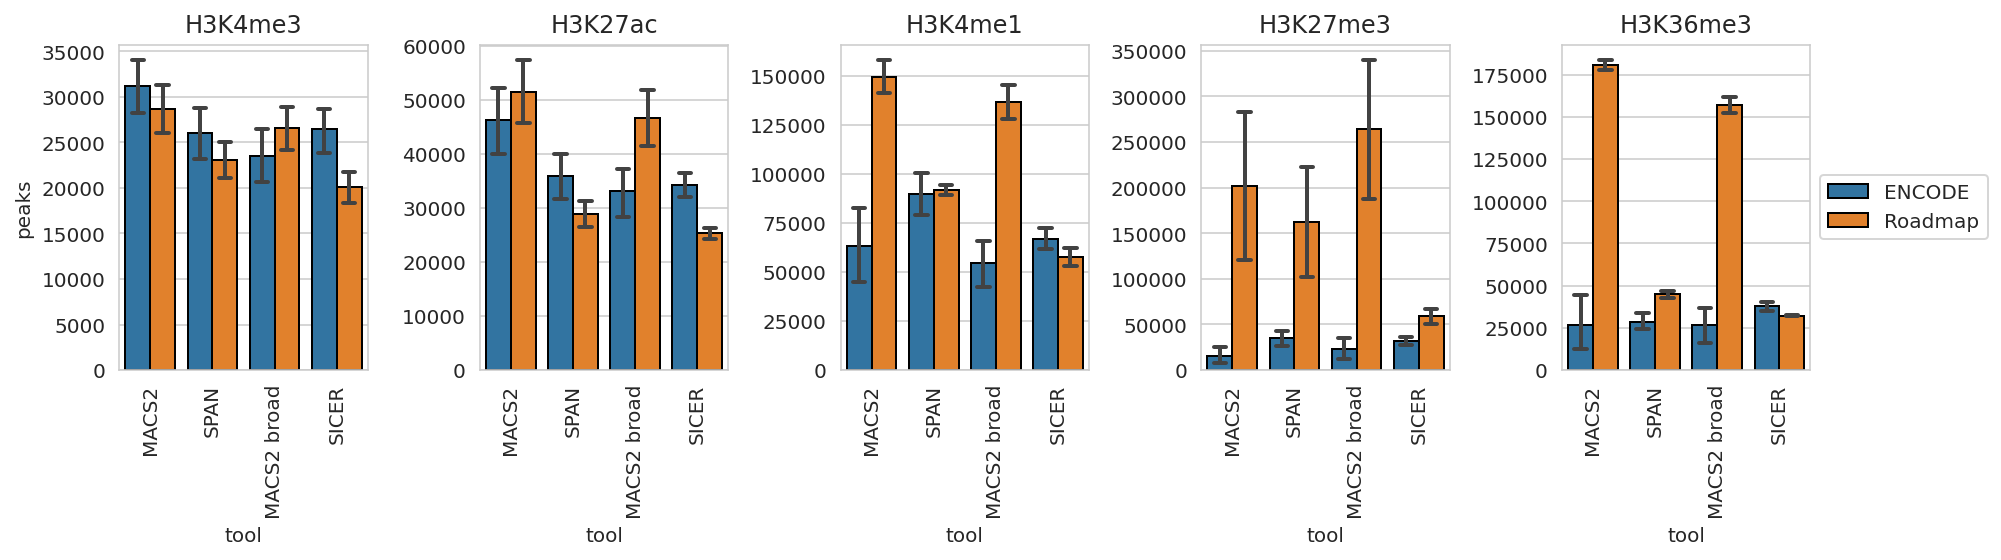

In [10]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

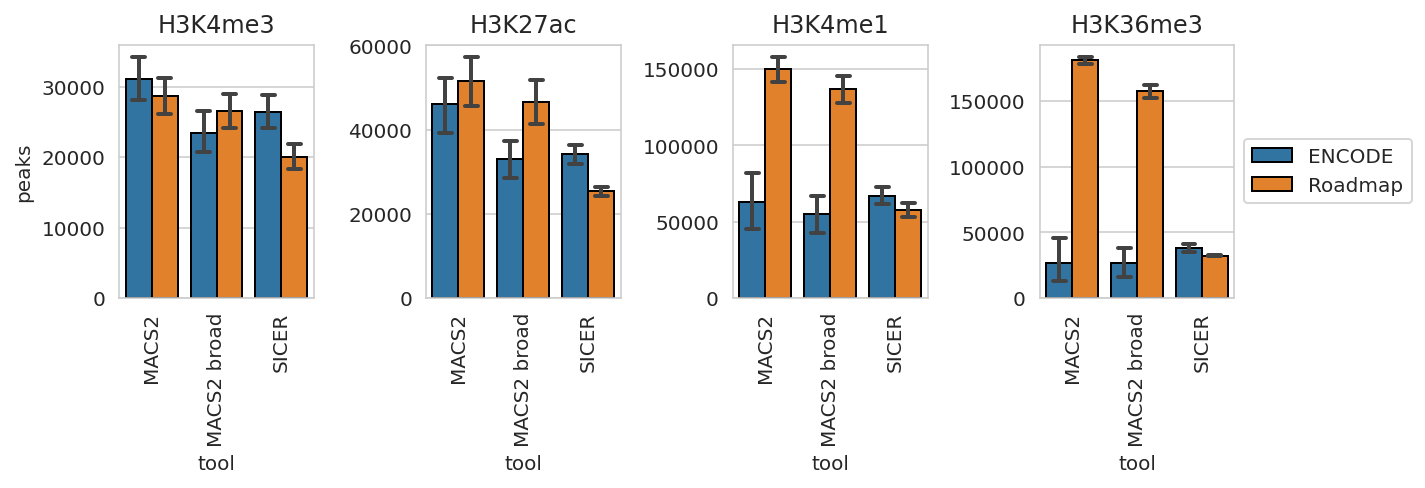

In [11]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

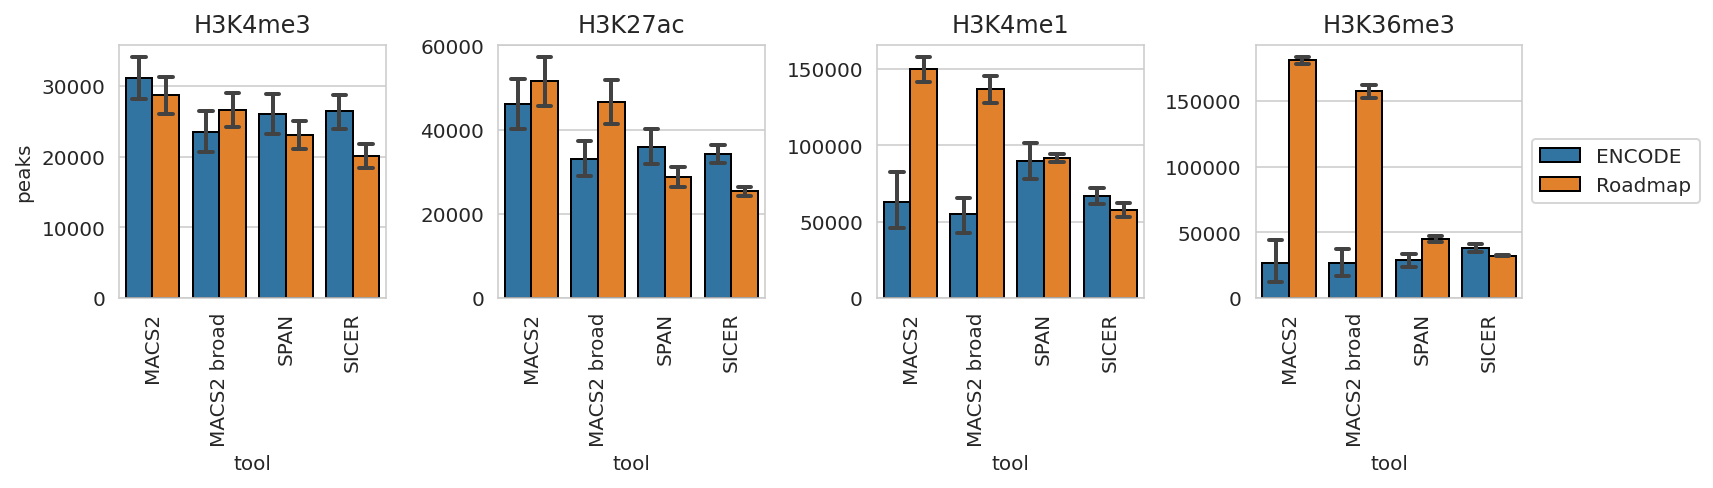

In [12]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length dataset modification     cell replicate         tool
1564376   999.0  ENCODE      H3K4me1     HSMM      rep1        SICER
1318678   722.0  ENCODE     H3K36me3     K562      rep2  MACS2 broad
763575   1518.0  ENCODE      H3K27ac     NHEK      rep2  MACS2 broad
1836099  1399.0  ENCODE      H3K27ac  GM12878      rep1        SICER
2067393  1799.0  ENCODE      H3K4me1       H1      rep1        SICER
2579453   357.0  ENCODE      H3K4me3     HSMM      rep2         SPAN
2380416   875.0  ENCODE      H3K27ac    Huvec      rep2         SPAN
545169    347.0  ENCODE     H3K36me3  GM12878      rep2        MACS2
1658690  1999.0  ENCODE     H3K27me3  GM12878      rep2        SICER
1421836   517.0  ENCODE      H3K27ac    HepG2      rep1  MACS2 broad

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


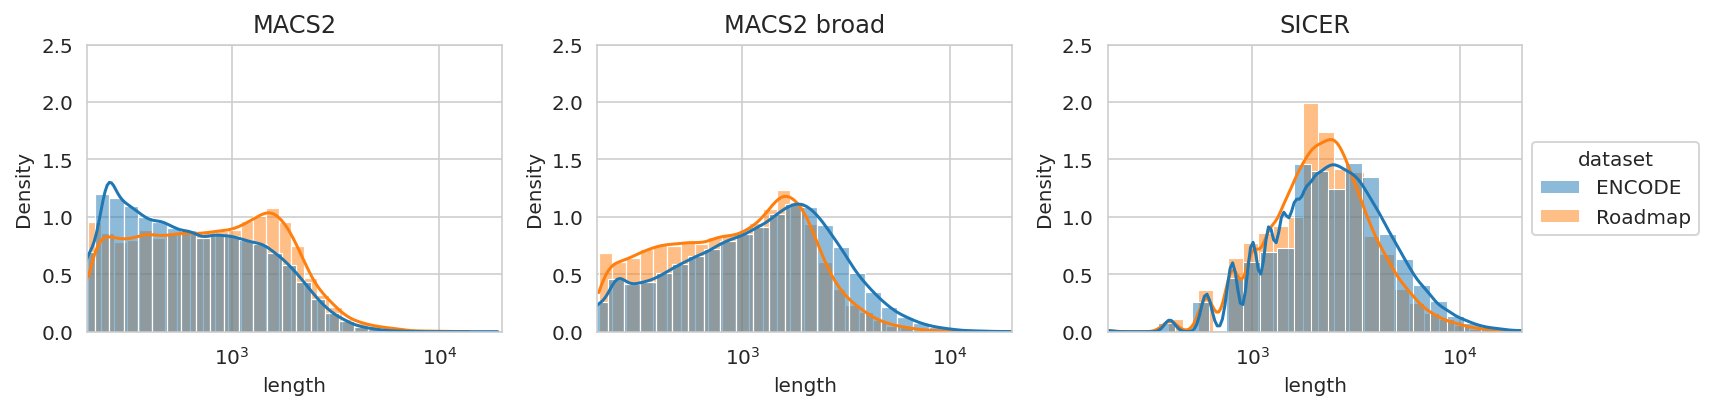

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


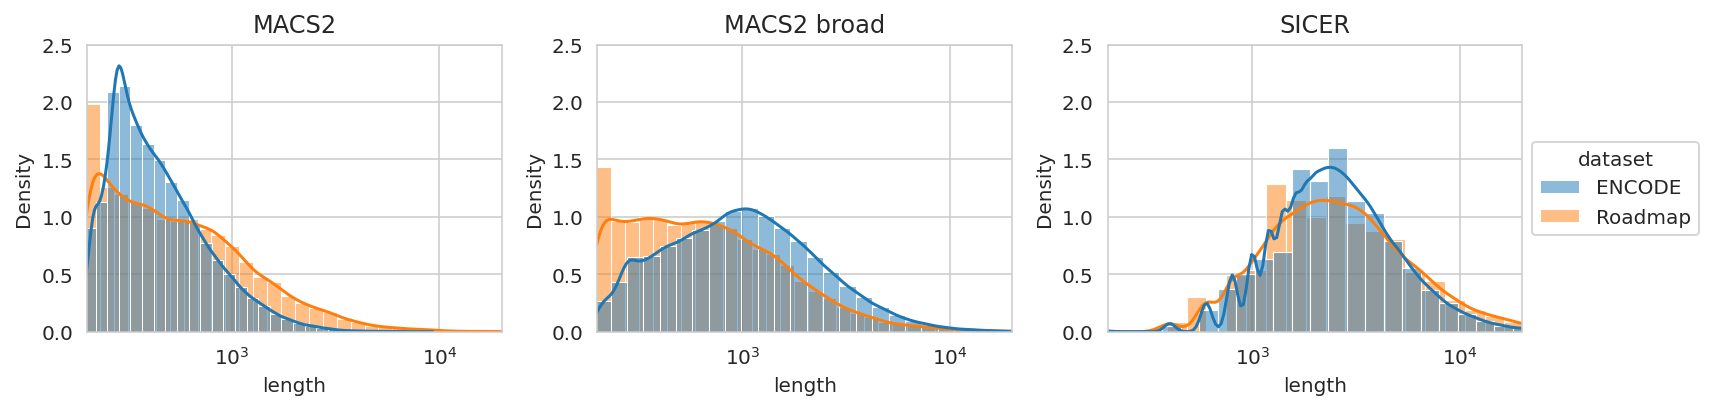

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


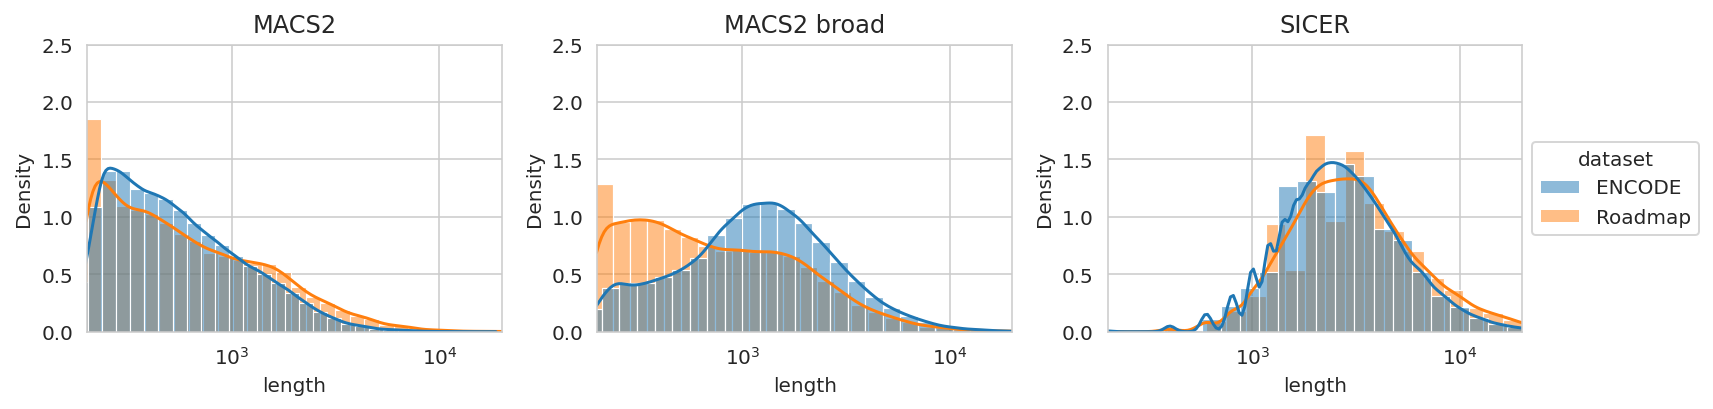

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


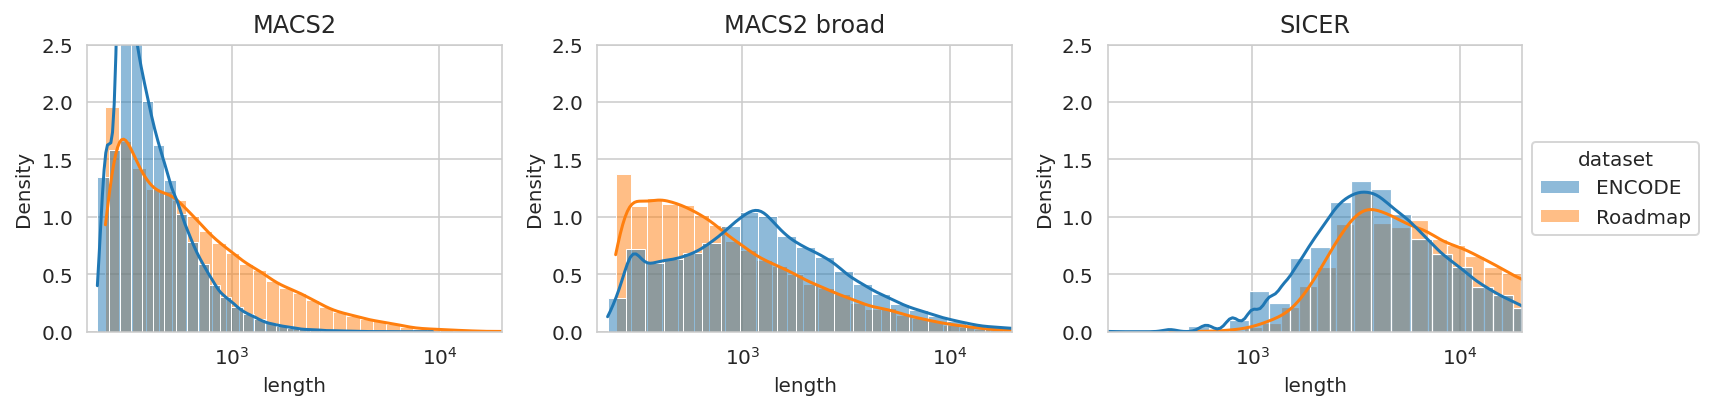

In [14]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


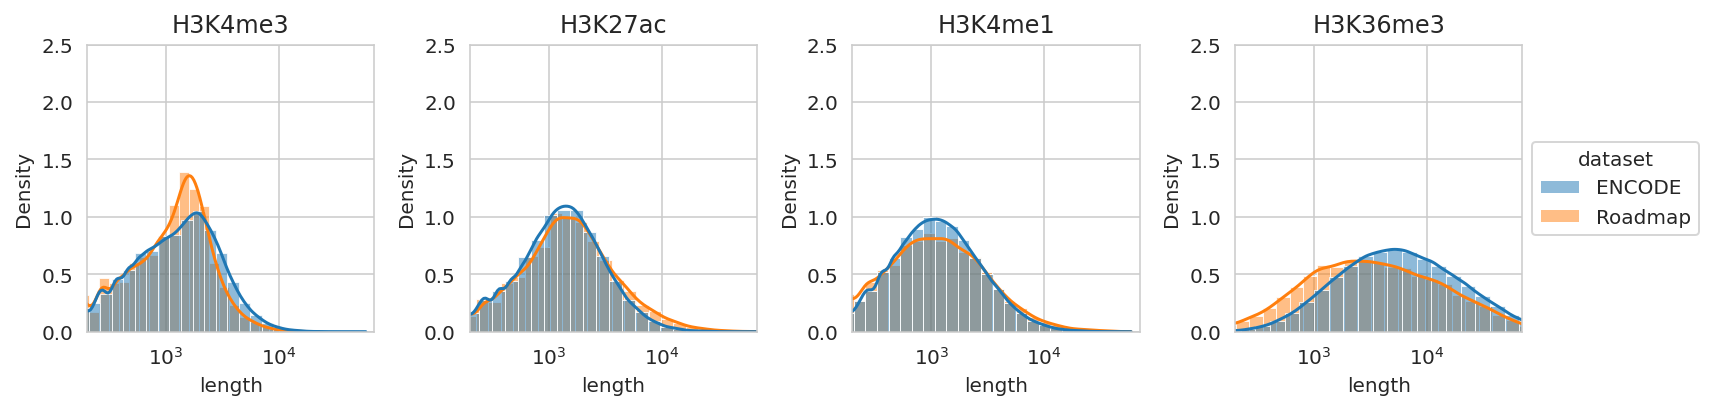

In [15]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [16]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification  cell replicate   tool     length
82   ENCODE     H3K27me3    H1      rep2  SICER  6726.1800
257  ENCODE      H3K4me1  NHEK      rep1   SPAN  1368.3195
16   ENCODE      H3K27ac  HMEC      rep2  MACS2   853.8167

H3K4me3
H3K27ac
H3K4me1
H3K36me3


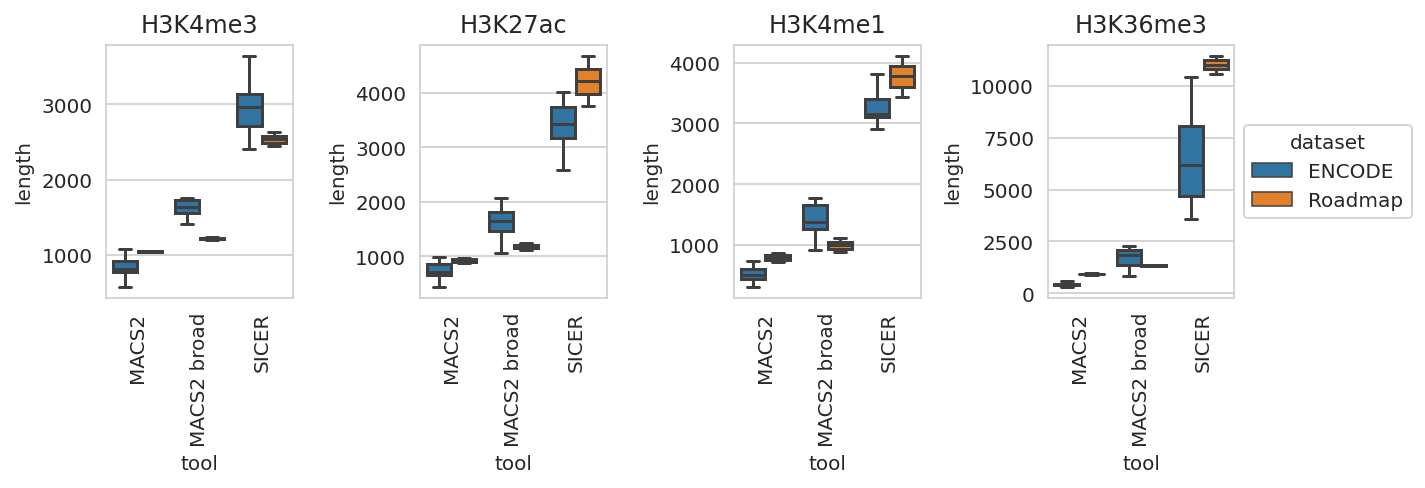

In [17]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, )
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Load downsampled peaks

In [18]:
# NOISE_PATH = os.path.expanduser('~/data/2023_Immune_noise')
NOISE_PATH = os.path.expanduser('~/data/2023_Immune_mln_control')

In [19]:
df_peaks_noise = load_peaks_path(NOISE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_peaks_noise.loc[[f'_{mln}mln' in file for file in df_peaks_noise['file']], 'quality'] = mln
df_peaks_noise.sample(3)

  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/352 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/45 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
64  /home/jetbrains/data/2023_Immune_mln_control/s...     H3K36me3  TCell   
6   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
40  /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   

   replicate  peaks         tool  quality  
64            26912        SICER        1  
6             96464        MACS2        5  
40            21945  MACS2 broad        1

In [20]:
t1 = df_peaks_noise[df_peaks_noise['quality'] == 10].copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

H3K27ac
H3K4me1


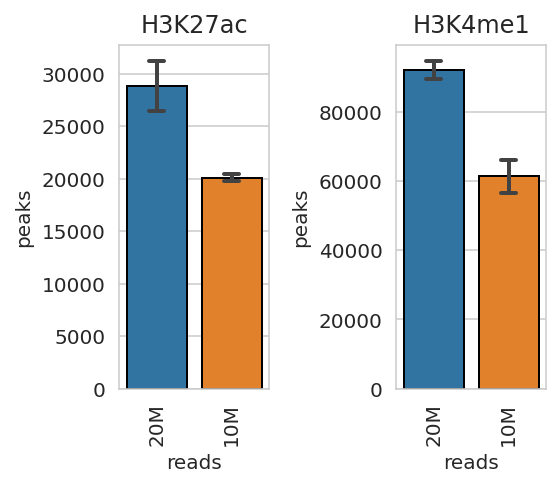

In [21]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) & 
                                               (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


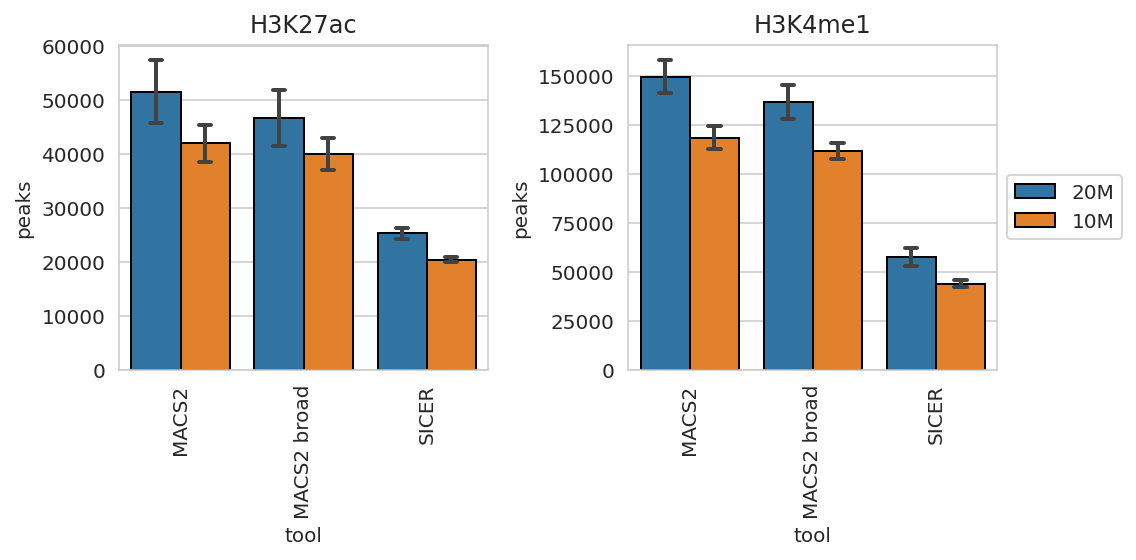

In [22]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [23]:
df_downsample_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool', 
                                         'peaks20M', 'peaks10M', 'fold-change'])
t = df_downsample[df_downsample['reads'] == '20M']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    t10 = df_downsample[(df_downsample['reads'] == '10M') &
                        (df_downsample['modification'] == m) &
                        (df_downsample['cell'] == c) &
                        (df_downsample['replicate'] == r) &
                        (df_downsample['tool'] == to)]
    if len(t10) == 0:
        continue
    p10 = t10['peaks'].values[0]
    df_downsample_fc.loc[len(df_downsample_fc)] = (m, c, r, to, p, p10, d(p10, p))
df_downsample_fc.sample(3)

0it [00:00, ?it/s]

H3K4me1 TCell  MACS2 158205
H3K27me3 BCell  MACS2 120947
H3K27me3 TCell  MACS2 283089
H3K4me1 BCell  MACS2 141414
H3K27ac TCell  MACS2 57350
H3K4me3 TCell  MACS2 31242
H3K36me3 TCell  MACS2 183613
H3K4me3 BCell  MACS2 26066
H3K27ac BCell  MACS2 45626
H3K36me3 BCell  MACS2 177956
H3K27ac TCell  MACS2 broad 51740
H3K4me1 BCell  MACS2 broad 127965
H3K27ac BCell  MACS2 broad 41460
H3K27me3 TCell  MACS2 broad 339795
H3K36me3 BCell  MACS2 broad 152502
H3K27me3 BCell  MACS2 broad 187656
H3K4me3 BCell  MACS2 broad 24118
H3K36me3 TCell  MACS2 broad 161765
H3K4me3 TCell  MACS2 broad 28929
H3K4me1 TCell  MACS2 broad 145437
H3K4me3 TCell  SICER 21785
H3K36me3 BCell  SICER 31862
H3K27ac TCell  SICER 26338
H3K27me3 BCell  SICER 50127
H3K4me1 BCell  SICER 62076
H3K27me3 TCell  SICER 67477
H3K36me3 TCell  SICER 32491
H3K27ac BCell  SICER 24342
H3K4me3 BCell  SICER 18342
H3K4me1 TCell  SICER 53056
H3K27ac TCell  SPAN 31192
H3K36me3 TCell  SPAN 47042
H3K27me3 BCell  SPAN 102270
H3K4me3 BCell  SPAN 21067

modification   cell replicate   tool  peaks20M  peaks10M  fold-change
24      H3K27ac  TCell             SPAN     31192     20408     0.654270
16      H3K4me3  TCell            SICER     21785     17900     0.821666
29      H3K27ac  BCell             SPAN     26454     19777     0.747600

H3K27ac
H3K4me1


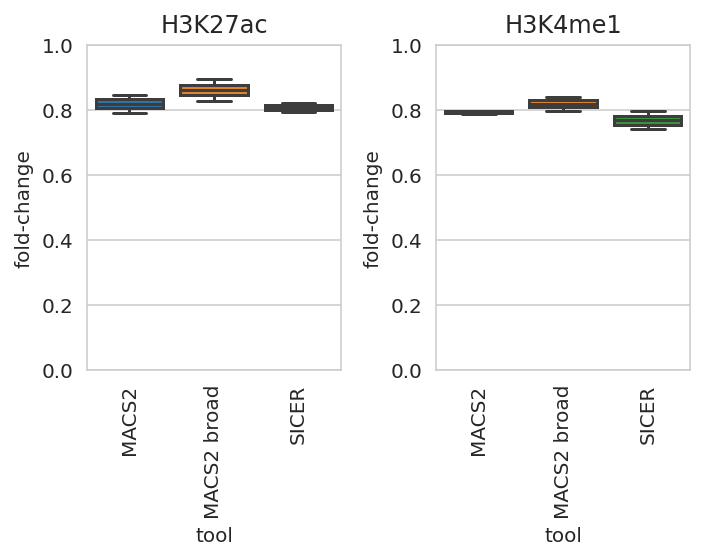

In [24]:
plt.figure(figsize=(5, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=df_downsample_fc[df_downsample_fc['modification'] == m],
                            x='tool', y='fold-change', ax=ax,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    # if i != 1:
    #     ax.legend().set_visible(False)
    # else:
        # Put a legend to the right of the current axis
        # g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [25]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification reads         tool
72622      253      H3K27ac   10M        MACS2
627802    1461      H3K27ac   20M         SPAN
680554   26608     H3K36me3   20M         SPAN
316260    1285     H3K36me3   10M         SPAN
318416    3447     H3K36me3   10M         SPAN
150449     885      H3K4me3   10M  MACS2 broad
430803     891      H3K4me1   20M  MACS2 broad
156630     979      H3K4me3   10M  MACS2 broad
549650    3599      H3K27ac   20M        SICER
449650    1204      H3K27ac   20M  MACS2 broad

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


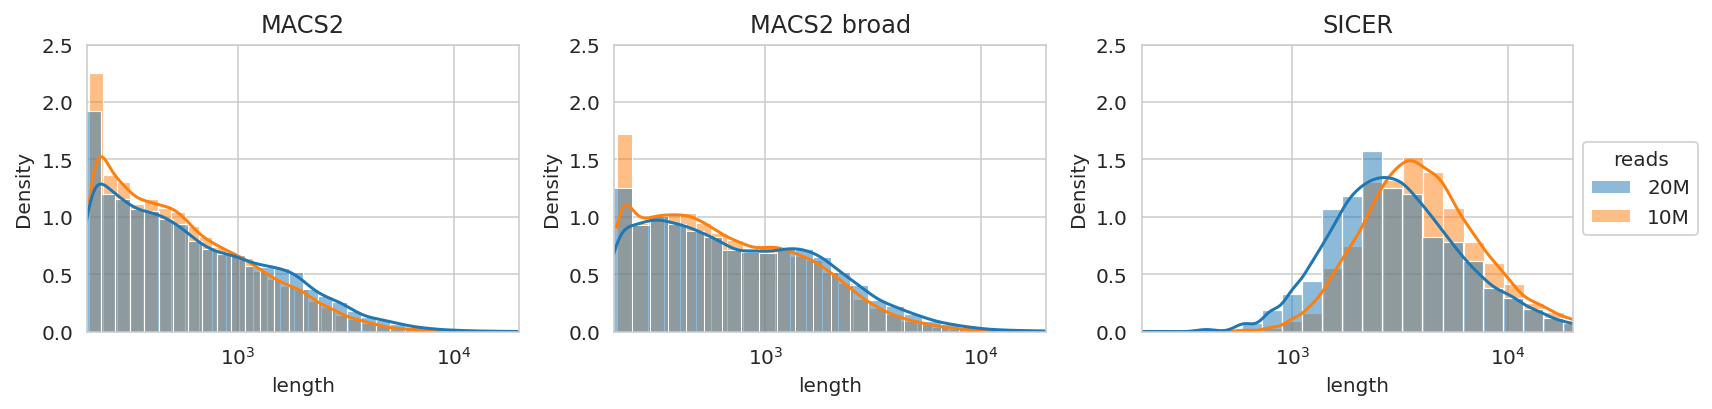

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


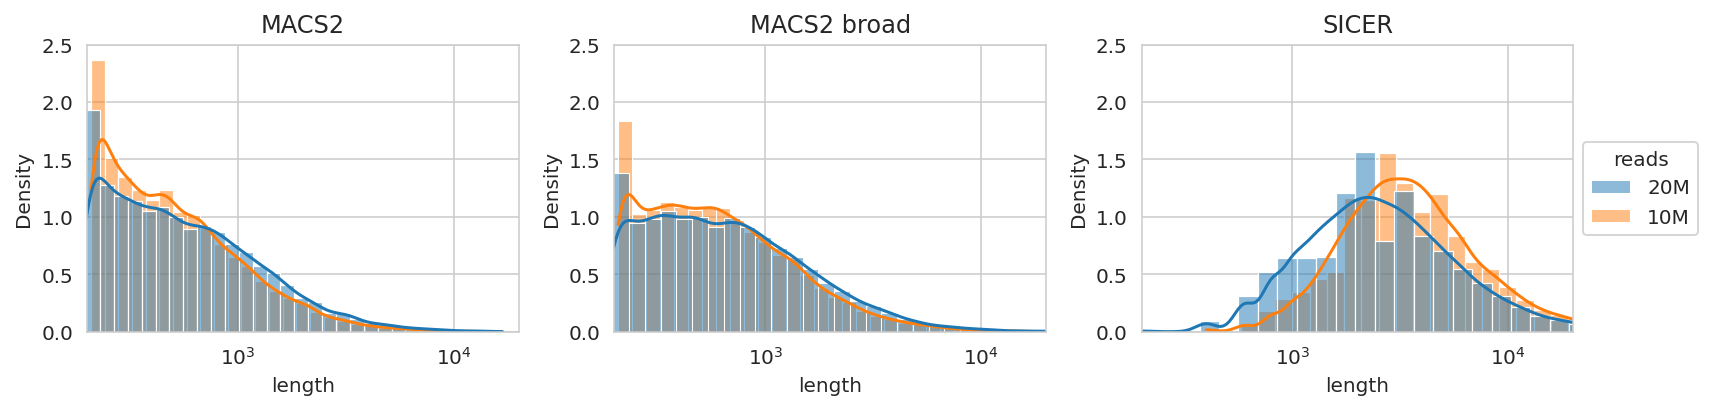

In [26]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['20M', '10M'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


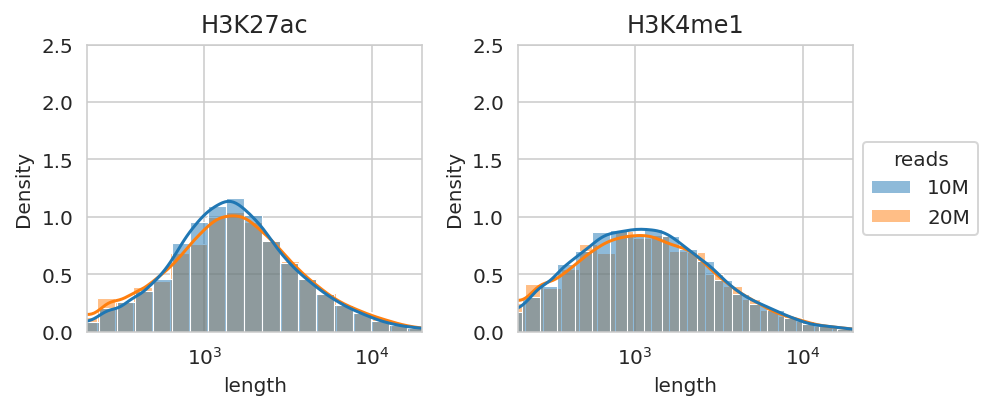

In [27]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


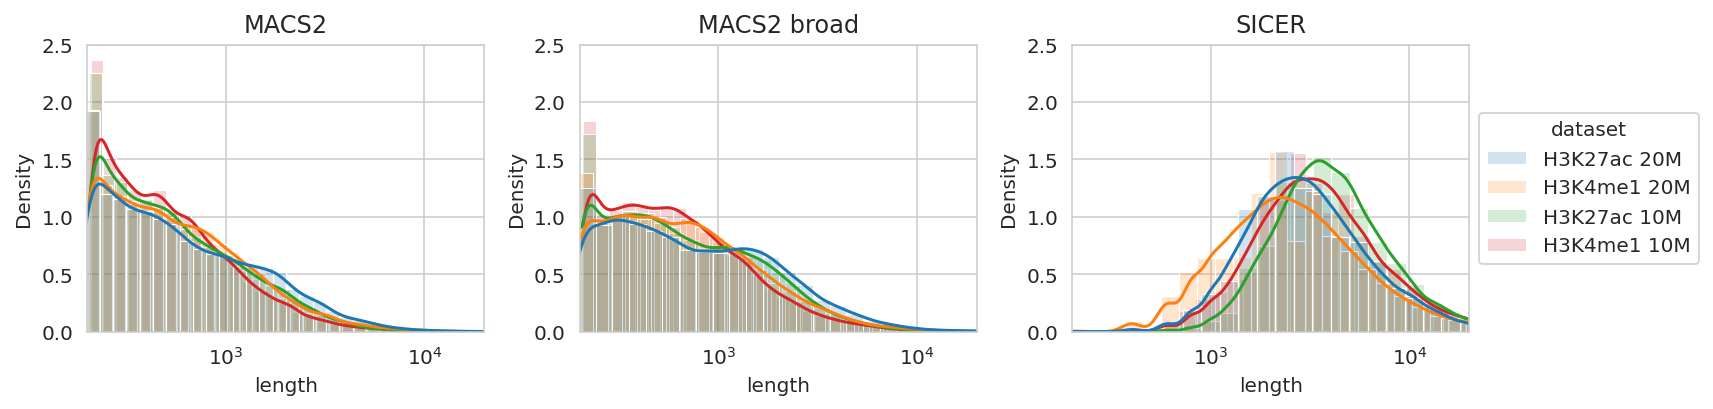

In [28]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(
        data=t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)],
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac 20M', 'H3K4me1 20M', 'H3K27ac 10M', 'H3K4me1 10M'],
        # palette=READS_PALETTE,
        )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [29]:
df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

In [30]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         (lines(file)), peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


0it [00:00, ?it/s]

H3K27ac BCell  MACS2
H3K27ac BCell  MACS2 broad
H3K27ac BCell  SPAN
H3K27ac BCell  SICER
H3K27ac TCell  MACS2
H3K27ac TCell  MACS2 broad
H3K27ac TCell  SPAN
H3K27ac TCell  SICER
H3K4me1 BCell  MACS2
H3K4me1 BCell  MACS2 broad
H3K4me1 BCell  SPAN
H3K4me1 BCell  SICER
H3K4me1 TCell  MACS2
H3K4me1 TCell  MACS2 broad
H3K4me1 TCell  SPAN
H3K4me1 TCell  SICER


modification   cell replicate   name quality  original_peaks  \
14      H3K4me1  TCell             SPAN     10M           94649   
6       H3K27ac  TCell             SPAN     10M           31192   
7       H3K27ac  TCell            SICER     10M           26338   

    original_peaks_len  peaks  peaks_len  overlap1  overlap2  overlap_len  
14           166428319  56530  108798100     51971     56523    107926202  
6             84894994  20408   51357646     18724     20398     51230543  
7            124149062  20866  117595134     20774     20659    101631057

In [31]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


modification   cell replicate  name quality  original_peaks  \
6      H3K27ac  TCell            SPAN     10M           31192   

   original_peaks_len  peaks  peaks_len  overlap1  overlap2  overlap_len  \
6            84894994  20408   51357646     18724     20398     51230543   

    jaccard  
6  0.602556

H3K27ac
H3K4me1


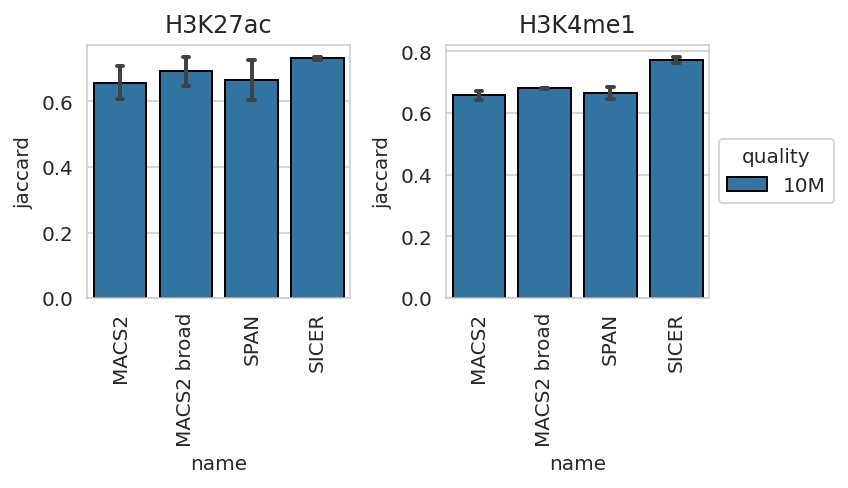

In [32]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute BAM coverage

In [33]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [34]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams.sample(3)

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification  cell  \
87  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  NHEK   
16  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  HMEC   
44  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3    H1   

   replicate     reads dataset  
87      rep2  10314582  ENCODE  
16      rep1  16351916  ENCODE  
44      rep2  12119359  ENCODE

In [35]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams.sample(3)

  0%|          | 0/35 [00:00<?, ?it/s]

bam_file modification   cell  \
8  /home/jetbrains/data/2023_Immune/bams/TCell_H3...     H3K27me3  TCell   
7  /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K27me3  BCell   
1  /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K27ac  BCell   

  replicate     reads  dataset  
8            25580386  Roadmap  
7            26056228  Roadmap  
1            21067933  Roadmap

In [36]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

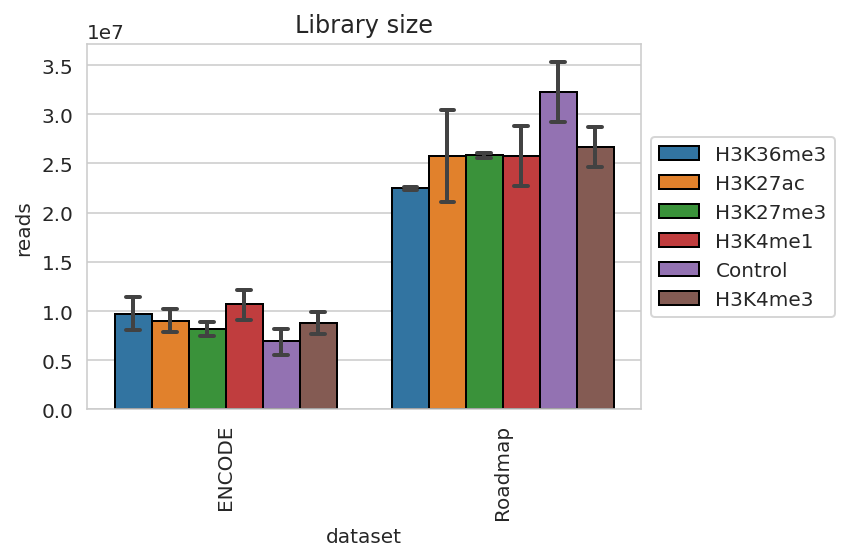

In [37]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

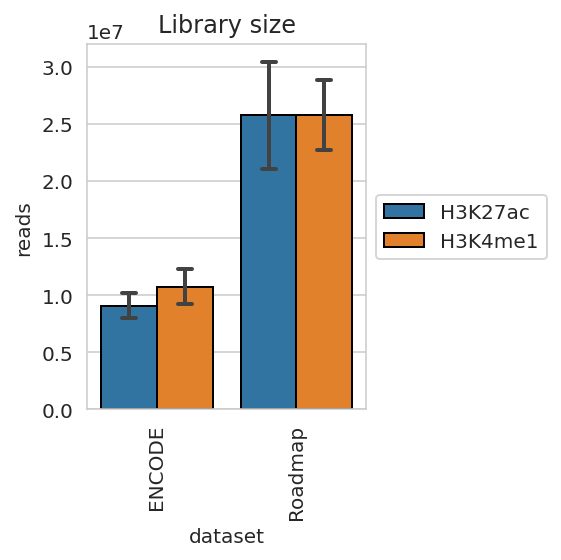

In [38]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

In [39]:
# Prepare bed files

WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      (~df_bams['cell'].isin(['H1'])) & 
                      (df_bams['replicate'] == 'rep1') &
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds.sample(3)

bam_file modification   cell  \
55  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1   K562   
28  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac   NHLF   
95  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  Huvec   

   replicate     reads dataset  
55      rep1   9537695  ENCODE  
28      rep1   7915513  ENCODE  
95      rep1  10460235  ENCODE

In [40]:
beds = []
for _, (bam_file, m, c, r, _, _) in df_bam_beds.iterrows():
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646380_HMEC_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646414_Huvec_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646492_NHLF_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646355_HepG2_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646476_NHLF_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646394_HSMM_H3K27ac_rep1.bed
/home/jetbrains/d

bam_file modification     cell  \
59  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
71  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
72  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   

   replicate    reads dataset  \
59      rep1  8817516  ENCODE   
71      rep1  4554228  ENCODE   
72      rep1  7049058  ENCODE   

                                             bed_file  
59  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
71  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
72  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Wiggle

In [41]:
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

wiggles = []
for _, row in tqdm(df_bam_beds.iterrows()):
    bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
    print('Wiggle', m, c, r, bed_file)
    if m == 'Control':
        wiggles.append(None)
        ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
        continue
    cs = 0.8 # if m == 'H3K27ac' else 0.9
    cw = 1.0 - cs    
    print('Signal', cs, 'Wiggle', cw)
    result_file = f'{WD}/bams/{m}_{c}_{r}_wiggle.bam'
    wiggles.append(result_file)
    print(result_file)
    if os.path.exists(result_file):
        continue
    t = pd.read_csv(bed_file, sep='\t', header=None)
    print('Reads', len(t))
    
    signal = t.sample(int(len(t) * cs))
    noise = t.sample(int(len(t) * cw))
    delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
    noise[1] += delta
    noise[2] += delta
    # Ensure generated reads have proper coordinates
    noise.loc[noise[1] < 1, 1] = 1
    noise.loc[noise[2] < 1, 2] = 1
    signal.to_csv(tf1, sep='\t', index=False, header=None)
    noise.to_csv(tf2, sep='\t', index=False, header=None)
    del t, signal, noise, delta
    ! cat {tf1} > {tf3}
    ! cat {tf2} >> {tf3}
    ! rm {tf1} {tf2}
    ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
    ! rm {tf3}
    ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
    ! rm {tf4}
    print('Done')
df_bam_beds['wiggle'] = wiggles
df_bam_beds.sample(3)

0it [00:00, ?it/s]

Wiggle H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 Wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_wiggle.bam
Wiggle Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
Wiggle Control HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
Wiggle H3K27ac HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
Signal 0.8 Wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_wiggle.bam
Wiggle H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
Signal 0.8 Wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_GM12878_rep1_wiggle.bam
Wiggle H3K4me1 HSMM rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed

bam_file modification  cell  \
58  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  K562   
10  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  HMEC   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  HSMM   

   replicate     reads dataset  \
58      rep1  11704712  ENCODE   
10      rep1   3750119  ENCODE   
29      rep1  11291330  ENCODE   

                                             bed_file  \
58  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
10  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                               wiggle  
58  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
10                                               None  
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Mix control

In [42]:
df_bam_beds

bam_file modification     cell  \
2   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
5   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
10  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
12  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
14  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
16  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
17  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
23  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
26  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
28  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
41  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HSMM   
49  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
53  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
55  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
58  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
59  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
70  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    HepG2   
71  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
72  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
78  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
95  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
98  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  GM12878   

   replicate     reads dataset  \
2       rep1   9377615  ENCODE   
5       rep1  10381382  ENCODE   
10      rep1   3750119  ENCODE   
12      rep1  10940745  ENCODE   
13      rep1  11008158  ENCODE   
14      rep1   8080332  ENCODE   
16      rep1  16351916  ENCODE   
17      rep1  12283487  ENCODE   
23      rep1   3235572  ENCODE   
26      rep1   7474026  ENCODE   
28      rep1   7915513  ENCODE   
29      rep1  11291330  ENCODE   
41      rep1  10745462  ENCODE   
49      rep1   8094298  ENCODE   
53      rep1   9110760  ENCODE   
55      rep1   9537695  ENCODE   
58      rep1  11704712  ENCODE   
59      rep1   8817516  ENCODE   
70      rep1  13707399  ENCODE   
71      rep1   4554228  ENCODE   
72      rep1   7049058  ENCODE   
78      rep1  10247593  ENCODE   
95      rep1  10460235  ENCODE   
98      rep1   5699825  ENCODE   

                                             bed_file  \
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
5   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
10  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
12  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
13  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
14  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
16  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
17  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
23  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
26  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
28  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
41  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
49  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
53  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
55  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
58  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
59  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
70  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
71  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
72  /home/jetbrains/d

In [43]:
mixtures = []
for _, row in tqdm(df_bam_beds.iterrows()):
    bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
    if m == 'Control':
        mixtures.append(None)
        continue
    print('Mix', m, c, r)
    result_file = f'{WD}/bams/{m}_{c}_{r}_mix.bam'
    mixtures.append(result_file)
    print(result_file)
    if os.path.exists(result_file):
        continue
    control_file = df_bam_beds[(df_bam_beds['cell'] == c) & 
                               (df_bam_beds['replicate'] == r) & 
                               (df_bam_beds['modification'] == 'Control')]['bed_file'].values[0]
    signal = pd.read_csv(bed_file, sep='\t', header=None)
    noise = pd.read_csv(control_file, sep='\t', header=None)
    signal_reads = len(signal)
    control_reads = len(noise)
    print('Signal', bed_file, signal_reads)
    print('Control', control_file, control_reads)
    signal = signal.sample(int(signal_reads * 0.5))
    noise = noise.sample(min(signal_reads, int(control_reads * 0.5)))
    signal.to_csv(tf1, sep='\t', index=False, header=None)
    noise.to_csv(tf2, sep='\t', index=False, header=None)
    ! cat {tf1} > {tf3}
    ! cat {tf2} >> {tf3}
    ! rm {tf1} {tf2}
    ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
    ! rm {tf3}
    ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
    ! rm {tf4}
    del signal, noise
    print('Done')

df_bam_beds['mix'] = mixtures 
df_bam_beds.sample(3)

0it [00:00, ?it/s]

Mix H3K27ac NHEK rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_mix.bam
Mix H3K27ac HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_mix.bam
Mix H3K4me1 GM12878 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_GM12878_rep1_mix.bam
Mix H3K4me1 HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_HSMM_rep1_mix.bam
Mix H3K4me1 HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_HMEC_rep1_mix.bam
Mix H3K27ac Huvec rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_Huvec_rep1_mix.bam
Mix H3K27ac HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HepG2_rep1_mix.bam
Mix H3K27ac NHLF rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHLF_rep1_mix.bam
Mix H3K27ac HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HSMM_rep1_mix.bam
Mix H3K4me1 K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_K562_rep1_mix.bam


bam_file modification   cell  \
41  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control   HSMM   
26  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  HepG2   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac   HSMM   

   replicate     reads dataset  \
41      rep1  10745462  ENCODE   
26      rep1   7474026  ENCODE   
29      rep1  11291330  ENCODE   

                                             bed_file  \
41  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
26  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                               wiggle  \
41                                               None   
26  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                                  mix  
41                                               None  
26  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-incomplete && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-incomplete;

```

In [44]:
df_peaks['name'] = df_peaks['tool']
df_peaks['type'] = 'original'

In [45]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS) 
wiggle_mix_peaks['name'] = wiggle_mix_peaks['tool']
wiggle_mix_peaks['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks.loc[mix_rows, 'name'] = wiggle_mix_peaks[mix_rows]['name'] + ' mix'
wiggle_mix_peaks.loc[mix_rows, 'type'] = 'mix'
wiggle_mix_peaks.loc[wiggle_rows, 'name'] = wiggle_mix_peaks[wiggle_rows]['name'] + ' wiggle'
wiggle_mix_peaks.loc[wiggle_rows, 'type'] = 'wiggle'

wiggle_mix_peaks.sample(3)

  0%|          | 0/256 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/256 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/40 [00:00<?, ?it/s]

SICER 40


  0%|          | 0/35 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
36  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HepG2   
62  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HMEC   
12  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHLF   

   replicate  peaks         tool                name    type  
36      rep1  37110  MACS2 broad     MACS2 broad mix     mix  
62      rep1  39638  MACS2 broad  MACS2 broad wiggle  wiggle  
12      rep1  17515        MACS2           MACS2 mix     mix

In [46]:
all_wiggle_mix_peaks = pd.concat([df_peaks[(df_peaks['dataset'] != 'Roadmap') & df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_peaks.sample(3)

file modification  cell  \
150  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HMEC   
215  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  NHLF   
160  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  NHEK   

    replicate  peaks   tool dataset          name    type  
150      rep1   3522  MACS2     NaN  MACS2 wiggle  wiggle  
215      rep1  61432  SICER     NaN  SICER wiggle  wiggle  
160      rep1  96948  MACS2     NaN  MACS2 wiggle  wiggle

In [47]:
# Remove outliers
display(all_wiggle_mix_peaks[(all_wiggle_mix_peaks['peaks'] < 20_000) | (all_wiggle_mix_peaks['peaks'] > 100_000)])
all_wiggle_mix_peaks = all_wiggle_mix_peaks[(all_wiggle_mix_peaks['peaks'] >= 20_000) | (all_wiggle_mix_peaks['peaks'] <= 100_000)].copy()

file modification     cell  \
2    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
5    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
10   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHEK   
12   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHEK   
15   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
19   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
24   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     K562   
43   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
49   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
50   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
65   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
102  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1       H1   
106  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     NHEK   
128  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     NHEK   
130  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     HSMM   
132  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     HMEC   
136  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
138  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
139  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
148  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
150  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
153  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
161  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
169  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
171  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
177  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     K562   
186  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
187  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
192  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHEK   
196  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
213  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
244  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   

    replicate   peaks         tool dataset                name      type  
2        rep1   17497        MACS2  ENCODE               MACS2  original  
5        rep1   10256        MACS2  ENCODE               MACS2  original  
10       rep1  110303        MACS2  ENCODE               MACS2  original  
12       rep2  116379        MACS2  ENCODE               MACS2  original  
15       rep2  145430        MACS2  ENCODE               MACS2  original  
19       rep2      18        MACS2  ENCODE               MACS2  original  
24       rep1  119713        MACS2  ENCODE               MACS2  original  
43       rep1   15680  MACS2 broad  ENCODE         MACS2 broad  original  
49       rep2   16682  MACS2 broad  ENCODE         MACS2 broad  original  
50       rep1   15699  MACS2 broad  ENCODE         MACS2 broad  original  
65       rep2      95  MACS2 broad  ENCODE         MACS2 broad  original  
102      rep2  130340         SPAN  ENCODE                SPAN  original  
106      rep1  107773         SPAN  ENCODE                SPAN  original  
128      rep2  115312         SPAN  ENCODE                SPAN  original  
130      rep2  111867         SPAN  ENCODE                SPAN  original  
132      rep2  134363         SPAN  ENCODE                SPAN  original  
136      rep1    3416        MACS2     NaN           MACS2 mix       mix  
138      rep1   11904        MACS2     NaN           MACS2 

H3K27ac
H3K4me1


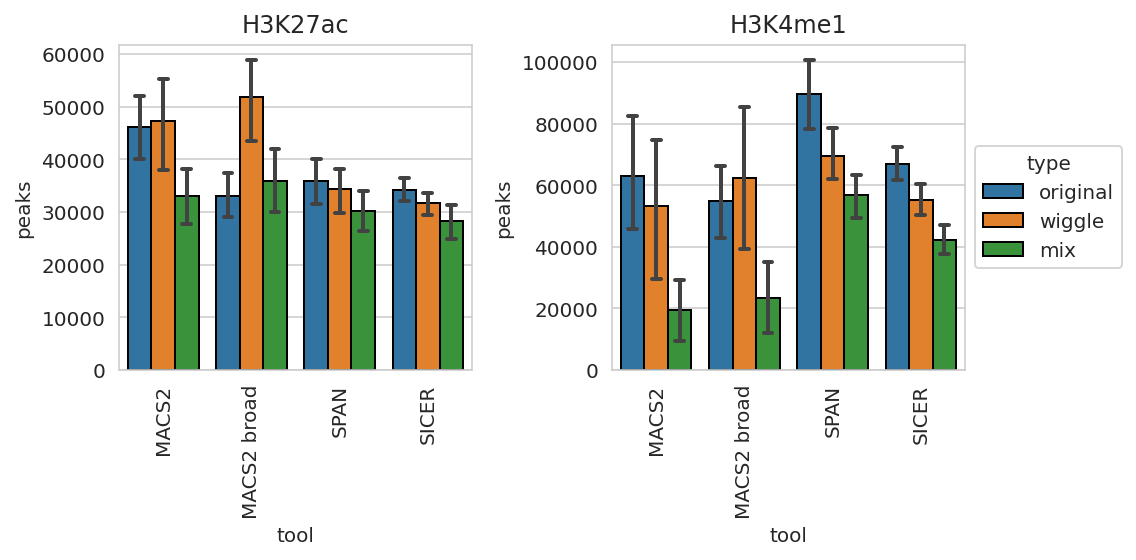

In [48]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['original', 'wiggle', 'mix']
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


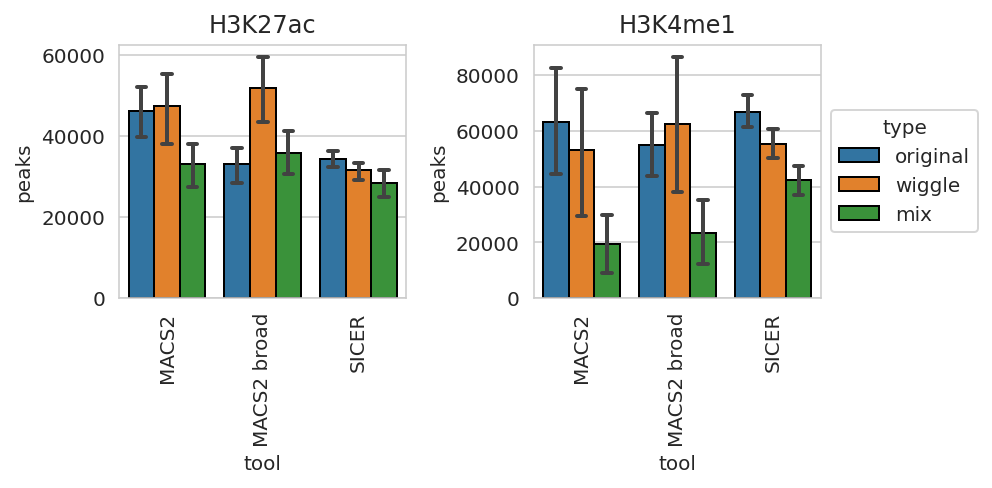

In [49]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


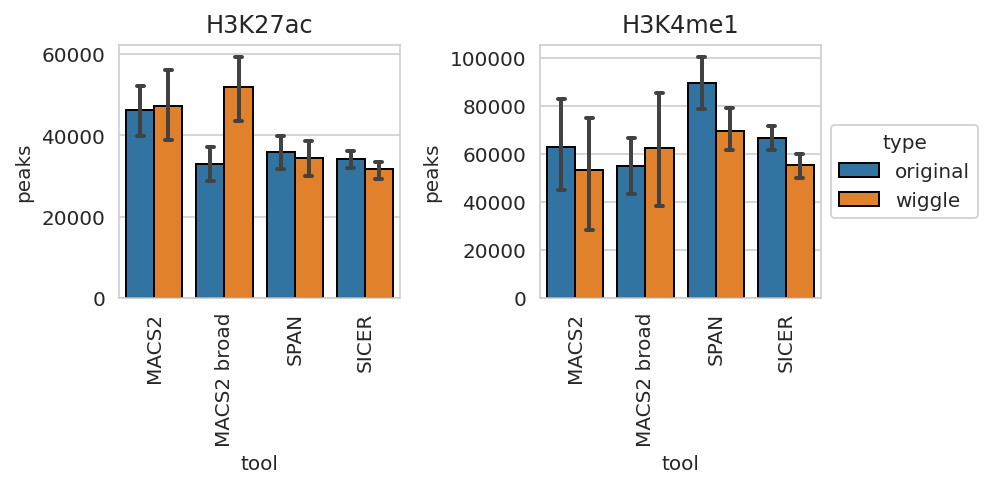

mix
H3K27ac
H3K4me1


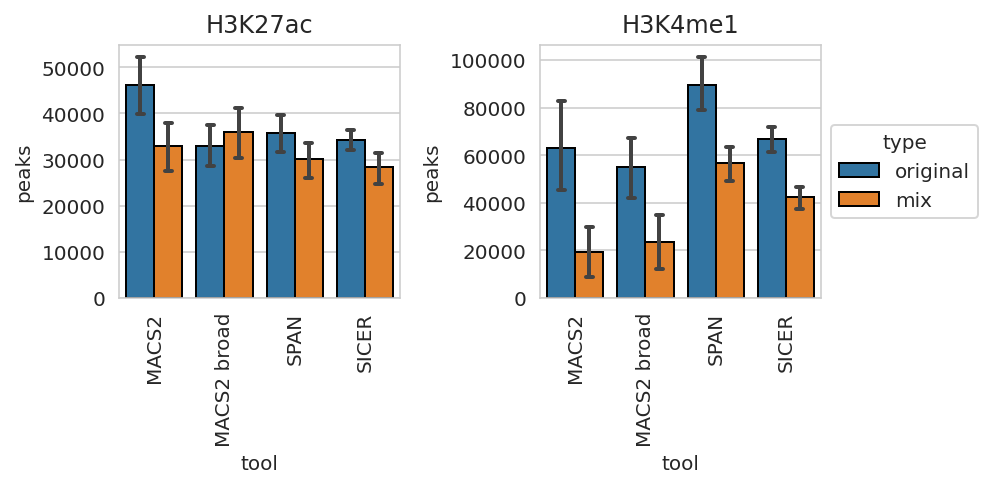

In [50]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

wiggle
H3K27ac
H3K4me1


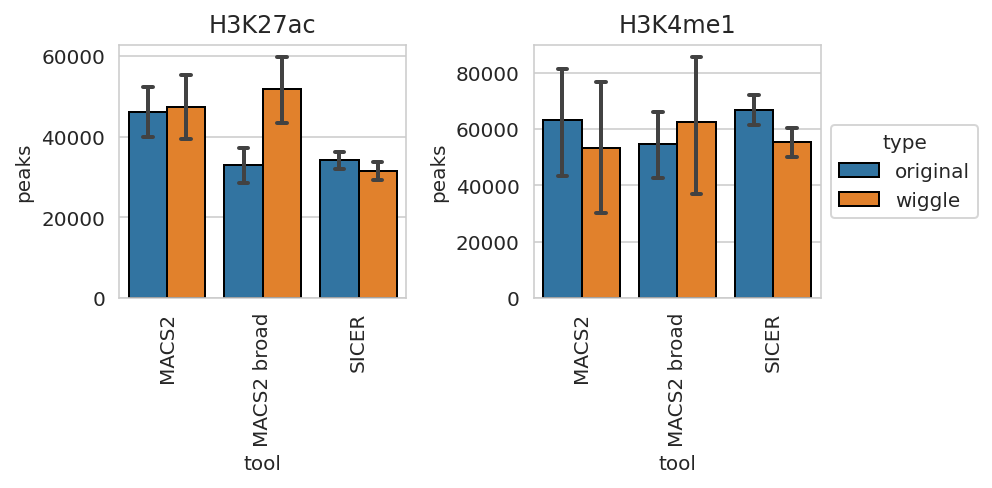

mix
H3K27ac
H3K4me1


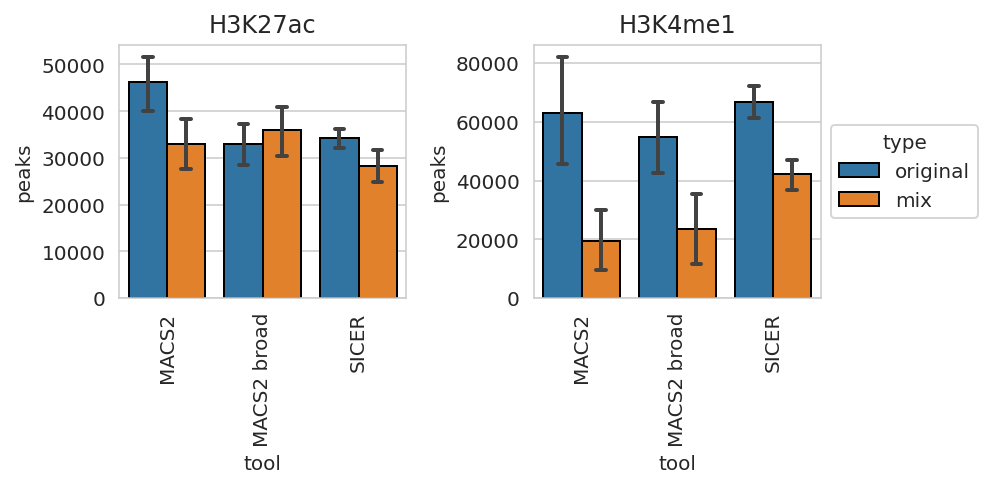

In [51]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [52]:
all_wiggle_mix_peaks_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool',
                                             'peaks_original', 'type', 'peaks', 'fold-change'])
t = all_wiggle_mix_peaks[all_wiggle_mix_peaks['dataset'] == 'ENCODE']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    for ty in ['wiggle', 'mix']:
        tty = all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == ty) &
                            (all_wiggle_mix_peaks['modification'] == m) &
                            (all_wiggle_mix_peaks['cell'] == c) &
                            (all_wiggle_mix_peaks['replicate'] == r) &
                            (all_wiggle_mix_peaks['tool'] == to)]
        if len(tty) == 0:
            continue
        pty = tty['peaks'].values[0]
        all_wiggle_mix_peaks_fc.loc[len(all_wiggle_mix_peaks_fc)] = (m, c, r, to, p, ty, pty, d(pty, p))
all_wiggle_mix_peaks_fc.sample(3)

0it [00:00, ?it/s]

H3K27ac HepG2 rep2 MACS2 26021
H3K27ac GM12878 rep2 MACS2 43917
H3K27ac H1 rep1 MACS2 17497
H3K27ac NHLF rep2 MACS2 61193
H3K27ac HepG2 rep1 MACS2 48652
H3K4me1 HMEC rep1 MACS2 10256
H3K4me1 NHLF rep2 MACS2 34236
H3K27ac K562 rep1 MACS2 53699
H3K4me1 HSMM rep2 MACS2 39204
H3K4me1 HSMM rep1 MACS2 58144
H3K4me1 NHEK rep1 MACS2 110303
H3K27ac HSMM rep2 MACS2 55891
H3K4me1 NHEK rep2 MACS2 116379
H3K4me1 NHLF rep1 MACS2 35453
H3K4me1 GM12878 rep1 MACS2 46817
H3K4me1 HMEC rep2 MACS2 145430
H3K27ac Huvec rep1 MACS2 50367
H3K27ac HSMM rep1 MACS2 57283
H3K4me1 H1 rep1 MACS2 29669
H3K4me1 H1 rep2 MACS2 18
H3K27ac GM12878 rep1 MACS2 47290
H3K27ac HMEC rep1 MACS2 40609
H3K4me1 Huvec rep1 MACS2 87943
H3K4me1 K562 rep2 MACS2 55038
H3K4me1 K562 rep1 MACS2 119713
H3K27ac NHEK rep2 MACS2 61182
H3K27ac Huvec rep2 MACS2 35178
H3K4me1 Huvec rep2 MACS2 54041
H3K27ac NHLF rep1 MACS2 29697
H3K4me1 HepG2 rep1 MACS2 87117
H3K4me1 GM12878 rep2 MACS2 42605
H3K27ac K562 rep2 MACS2 39718
H3K27ac NHEK rep1 MACS2 63

modification   cell replicate         tool  peaks_original    type  peaks  \
82       H3K27ac   NHLF      rep1        SICER           38037  wiggle  34163   
112      H3K4me1  Huvec      rep1         SPAN           75212  wiggle  64235   
52       H3K4me1   HSMM      rep1  MACS2 broad           66078  wiggle  46270   

     fold-change  
82      0.898152  
112     0.854053  
52      0.700233

wiggle
H3K27ac
H3K4me1


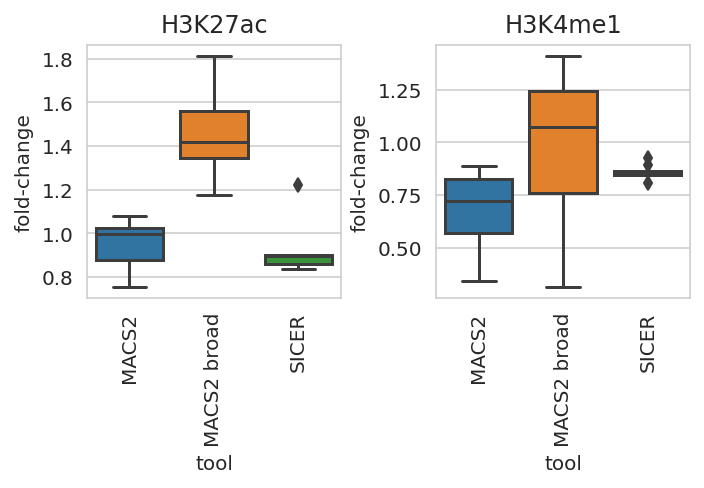

mix
H3K27ac
H3K4me1


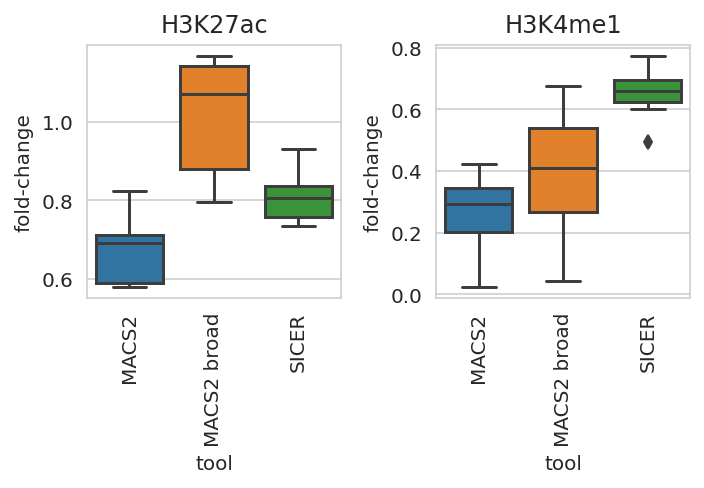

In [53]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=all_wiggle_mix_peaks_fc[
            (all_wiggle_mix_peaks_fc['modification'] == m) & 
            (all_wiggle_mix_peaks_fc['type']==ty)],
                                x='tool', y='fold-change', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

H3K27ac
H3K4me1


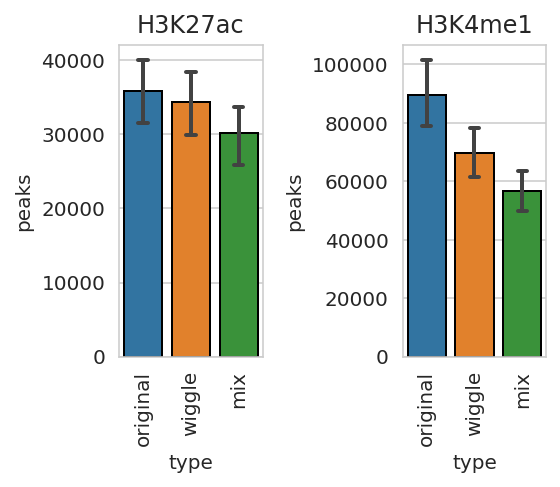

In [54]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & (all_wiggle_mix_peaks['tool'] == 'SPAN')],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


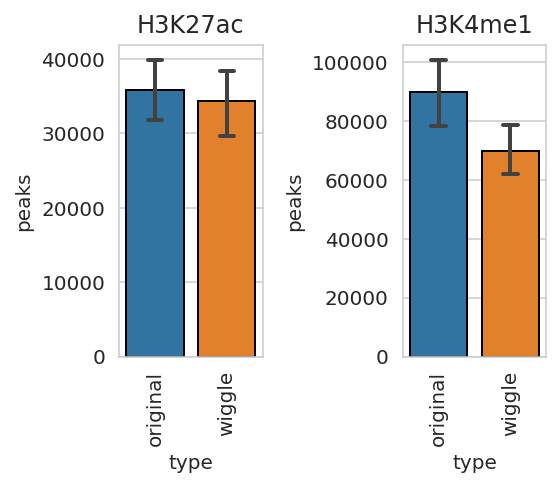

In [55]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) &
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN') &
                                                      (all_wiggle_mix_peaks['type'].isin(['original', 'wiggle']))],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [56]:
print('Load lengths')
ts = []
for ds, m, c, r, ty, file, tool in tqdm(zip(
        all_wiggle_mix_peaks['dataset'],
        all_wiggle_mix_peaks['modification'],
        all_wiggle_mix_peaks['cell'],
        all_wiggle_mix_peaks['replicate'],
        all_wiggle_mix_peaks['type'], all_wiggle_mix_peaks['file'], all_wiggle_mix_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = ds
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length dataset modification     cell replicate      type         tool
695655     7399  ENCODE      H3K27ac    Huvec      rep2  original        SICER
2313424    2399     NaN      H3K27ac    HepG2      rep1      base        SICER
1225750     377  ENCODE      H3K27ac     NHEK      rep1  original         SPAN
2541507    1362     NaN      H3K27ac  GM12878      rep1       mix         SPAN
2413486     947     NaN      H3K4me1     HMEC      rep1       mix         SPAN
1223832     518  ENCODE      H3K27ac     NHEK      rep1  original         SPAN
949636     4399  ENCODE      H3K4me1     NHLF      rep1  original        SICER
1244381    2719  ENCODE      H3K27ac     NHEK      rep2  original         SPAN
2360613    4187     NaN      H3K4me1     HSMM      rep1       mix         SPAN
1779737     453     NaN      H3K27ac  GM12878      rep1       mix  MACS2 broad

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


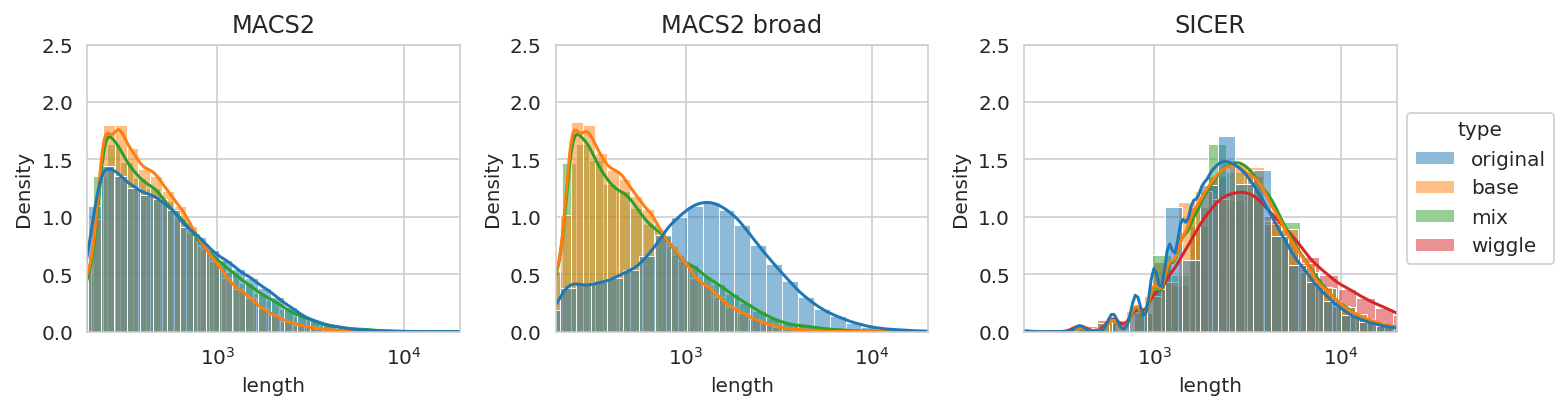

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


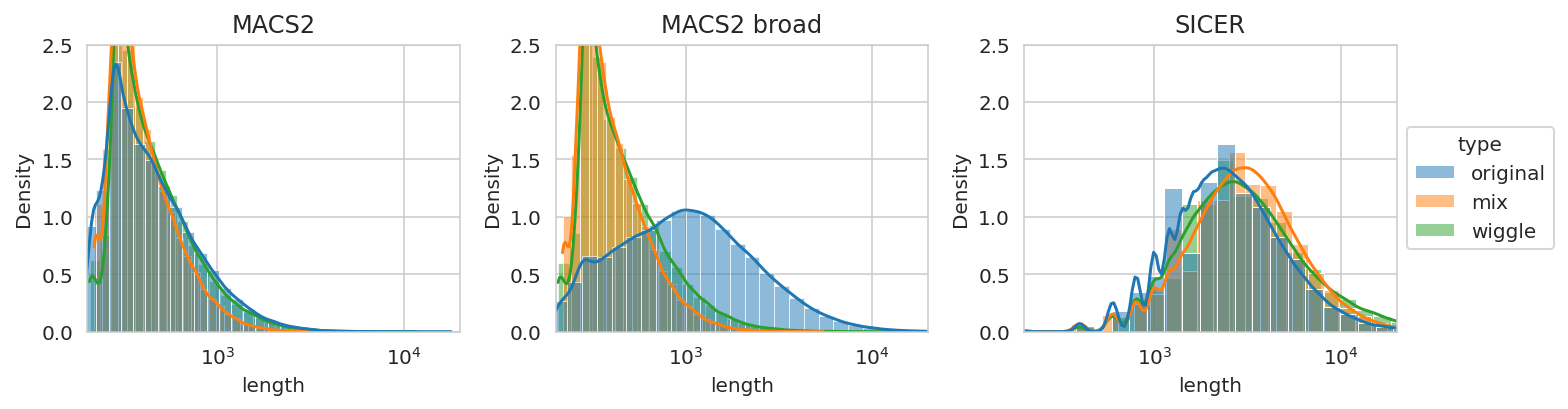

In [57]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(11, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='type', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


wiggle
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


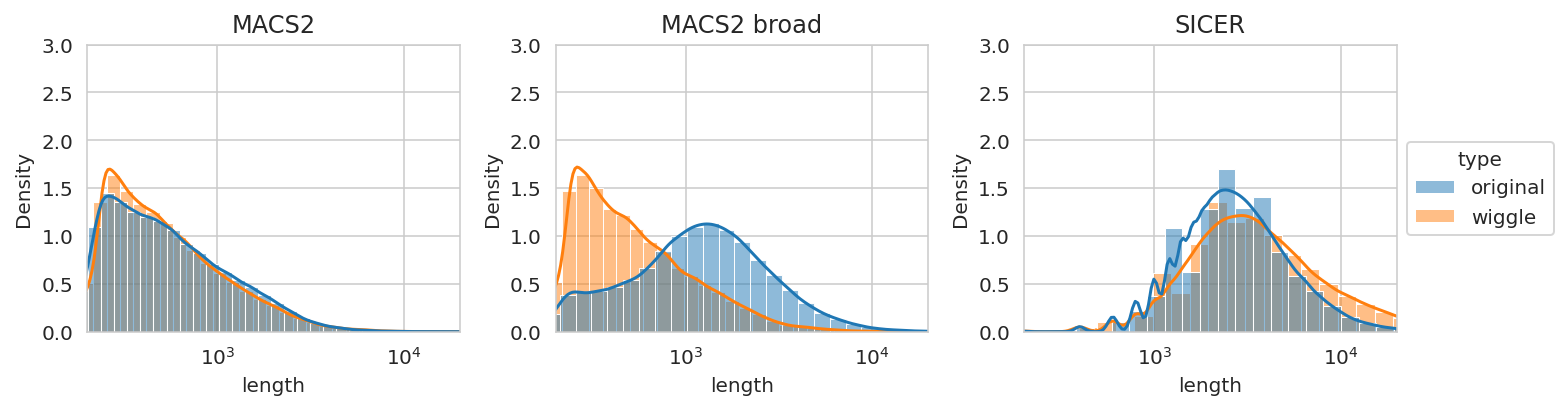

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


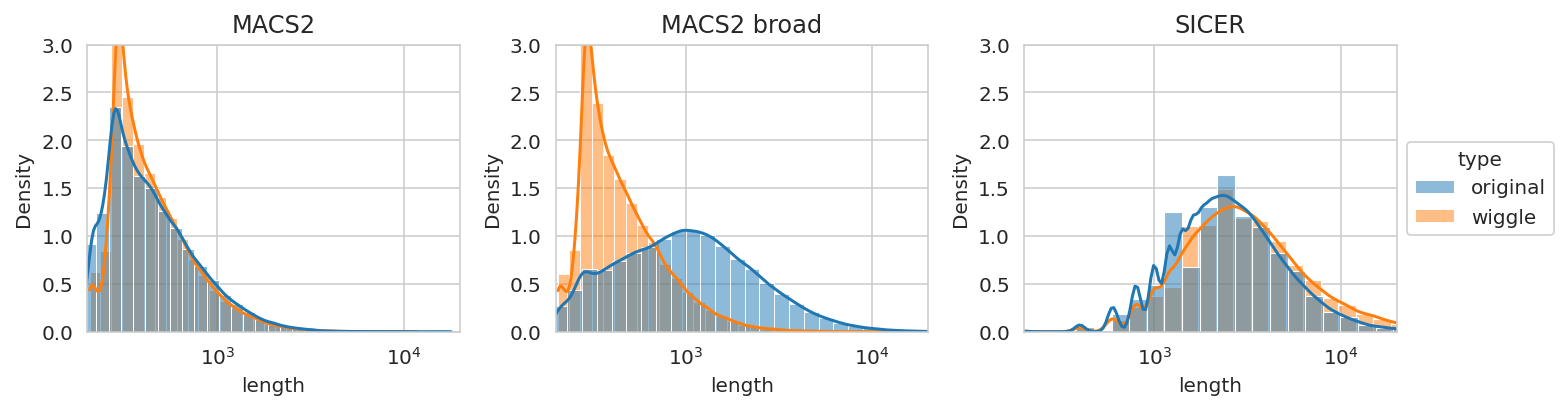

mix
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


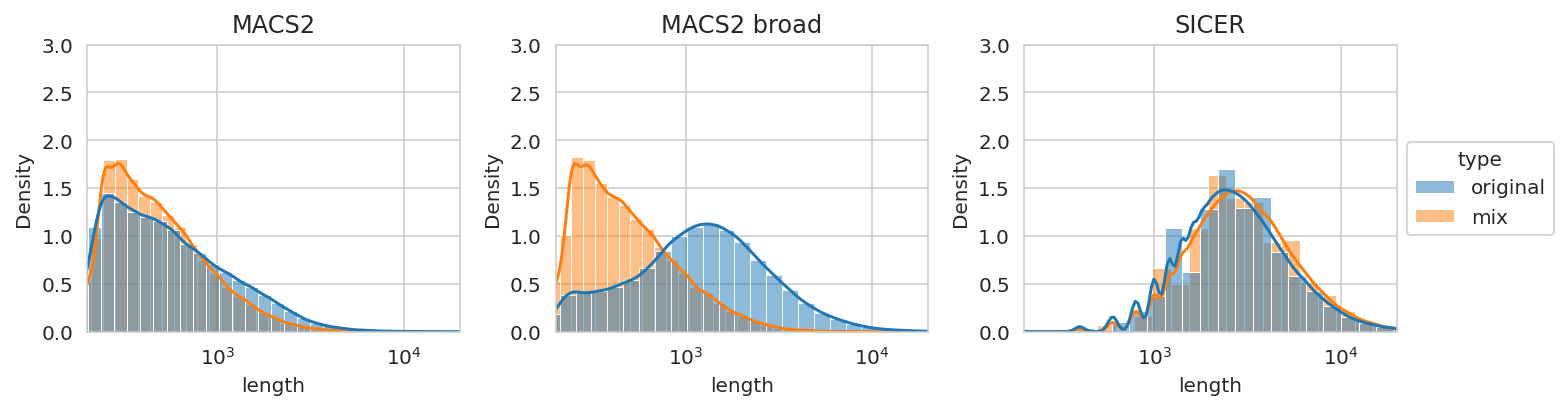

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


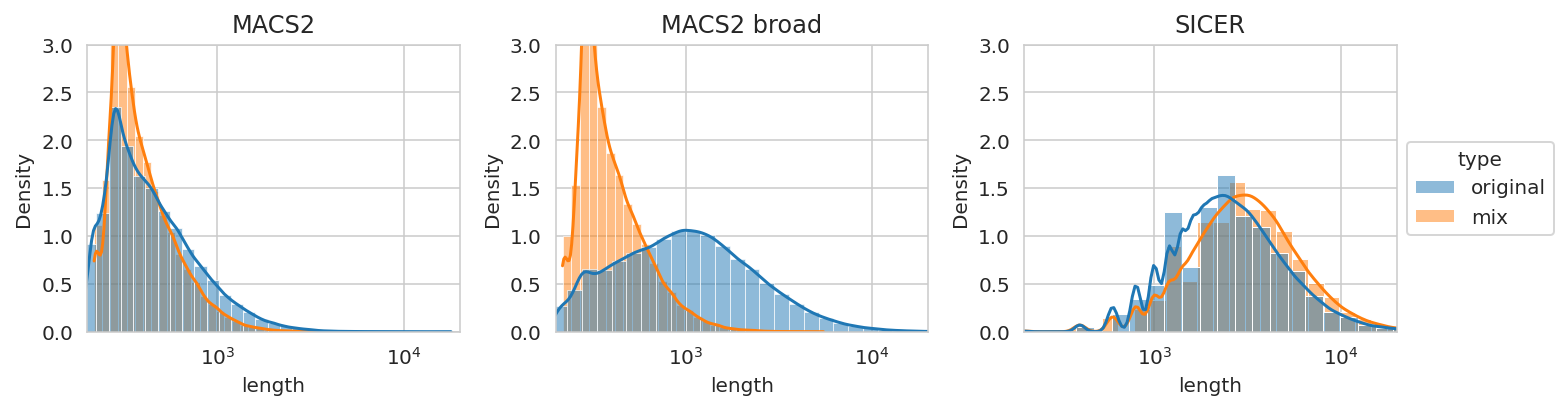

In [58]:
for ty in ['wiggle', 'mix']:
    print(ty)
    for m in ['H3K27ac', 'H3K4me1']:
        print(m)
        plt.figure(figsize=(11, 3))
        axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
        for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
            ax = axs[i]
            g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool) & (t['type'].isin(['original', ty]))],
                                     x='length', hue='type', ax=ax,
                                     stat='density', common_bins=False, common_norm=False,
                                     bins=30, kde=True, log_scale=True, alpha=0.5,
                                     )
            g_results.set(xscale='log')
            g_results.set_ylim(0, 3)
            g_results.set_xlim(200, 2e4)
            ax.title.set_text(f'{tool}')
            if i < 2:
                ax.legend().set_visible(False)
            else:
                sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


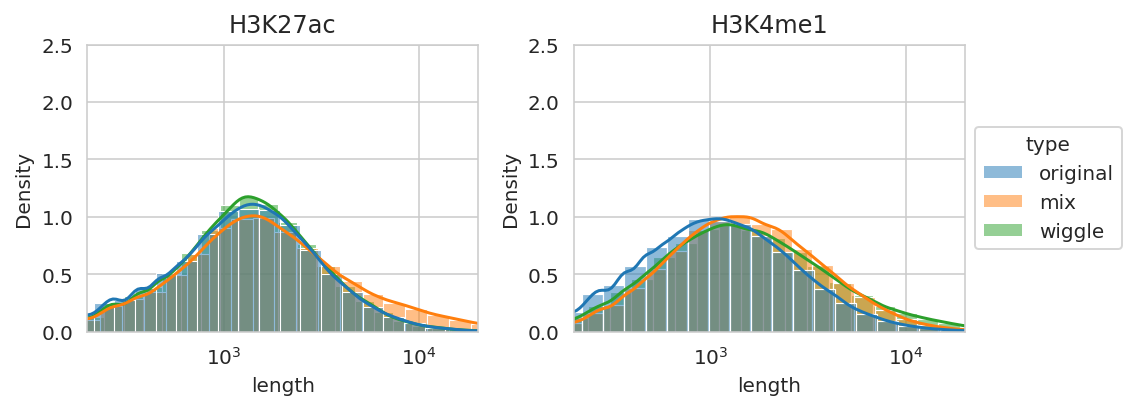

In [59]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


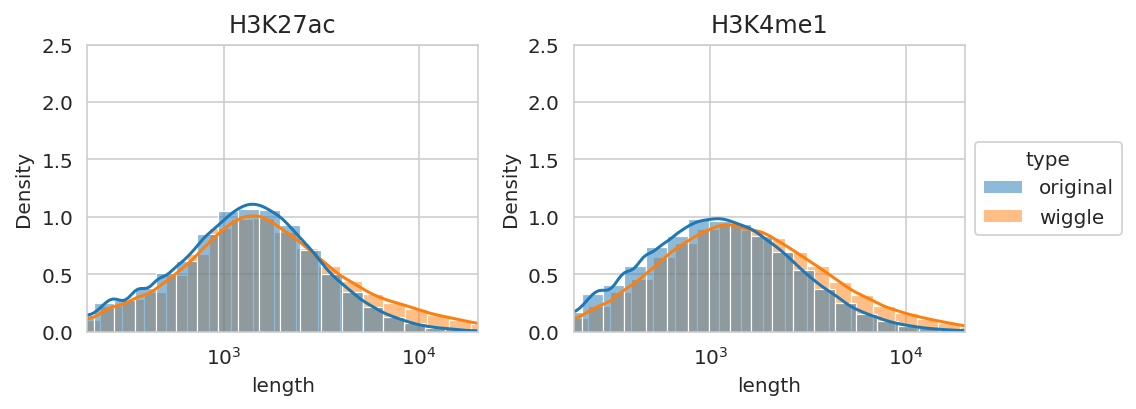

In [60]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & 
                                    (t['tool'] == 'SPAN') & 
                                    (t['type'].isin(['original', 'wiggle']))],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


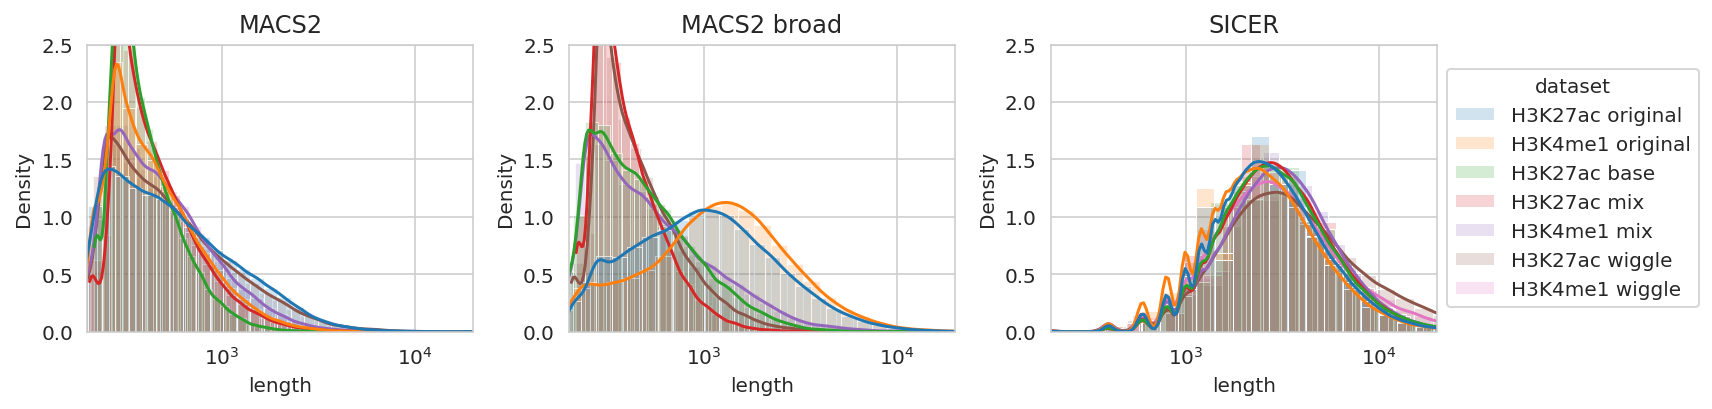

In [61]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


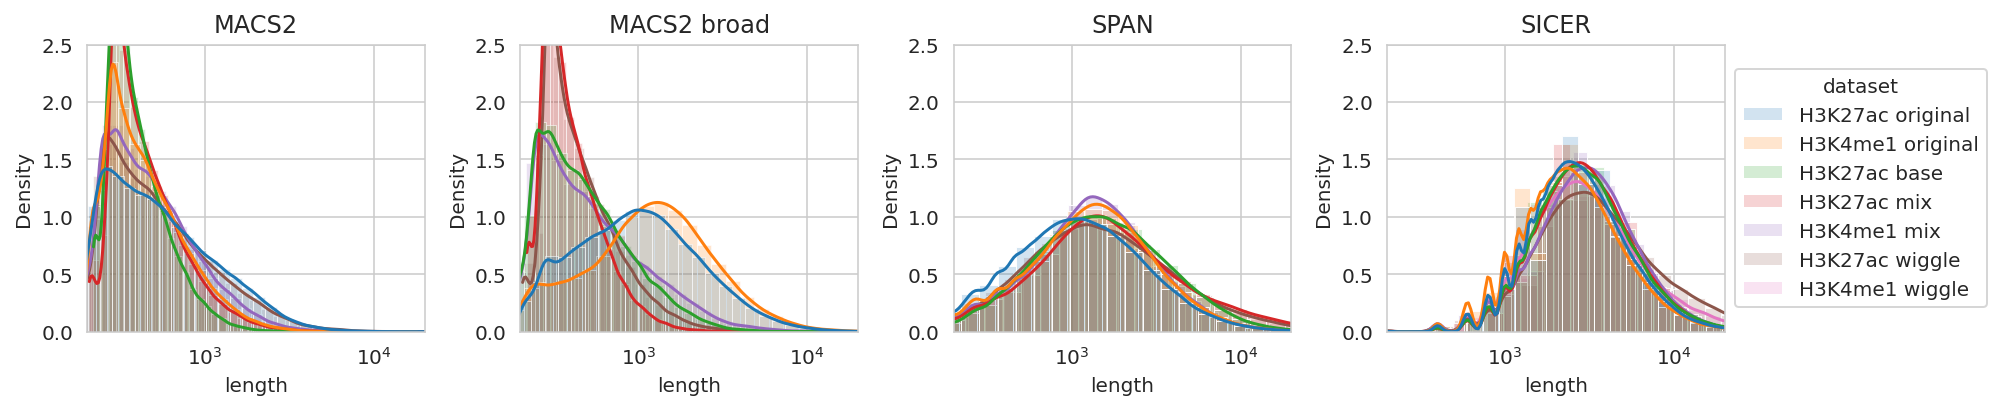

In [62]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [63]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'type', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'type', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification   cell replicate    type   tool     length
254  H3K4me1 wiggle      H3K4me1  HepG2      rep1  wiggle  SICER  4041.9400
23      H3K27ac mix      H3K27ac  HepG2      rep1     mix   SPAN  2035.0246
15      H3K27ac mix      H3K27ac   HMEC      rep1     mix   SPAN  1702.8472

wiggle
H3K27ac
H3K4me1


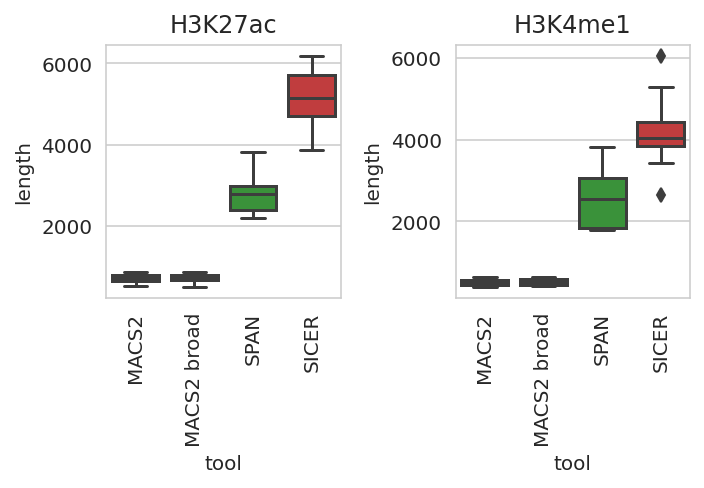

mix
H3K27ac
H3K4me1


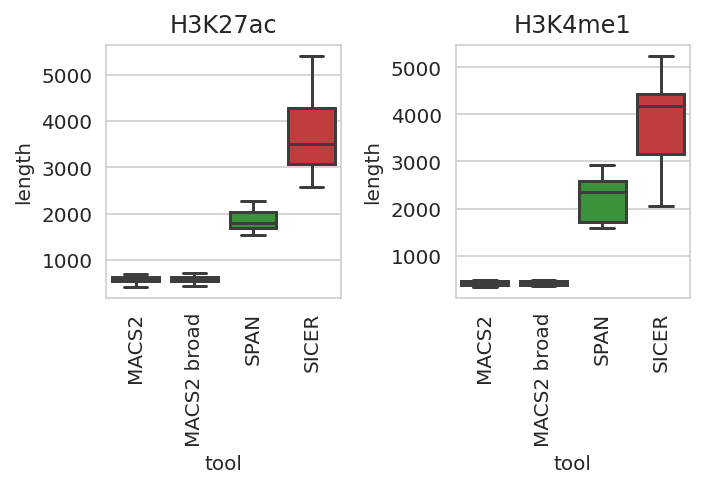

In [64]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=t_aggr[
            (t_aggr['modification'] == m) &
            (t_aggr['type']==ty)],
                                x='tool', y='length', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Prepare union peaks

In [65]:
all_wiggle_mix_roadmap_peaks = pd.concat([df_peaks[df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
                                          wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_roadmap_peaks['dataset'] = [ds if ty == 'original' else ty for ds, ty in zip(all_wiggle_mix_roadmap_peaks['dataset'], all_wiggle_mix_roadmap_peaks['type'])]
all_wiggle_mix_roadmap_peaks.sample(3)

file modification     cell  \
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  GM12878   
187  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
153  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   

    replicate  peaks         tool dataset             name      type  
1        rep2  43917        MACS2  ENCODE            MACS2  original  
187      rep1   3535  MACS2 broad     mix  MACS2 broad mix       mix  
153      rep1  64893        MACS2  wiggle     MACS2 wiggle    wiggle

In [66]:
# Remove outliers
display(all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['peaks'] < 20_000) | (all_wiggle_mix_roadmap_peaks['peaks'] > 100_000)])
all_wiggle_mix_roadmap_peaks = all_wiggle_mix_roadmap_peaks[
    (all_wiggle_mix_roadmap_peaks['peaks'] >= 20_000) | (all_wiggle_mix_roadmap_peaks['peaks'] <= 100_000)].copy()

file modification     cell  \
2    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
5    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
10   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHEK   
12   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHEK   
15   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
19   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
24   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     K562   
43   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
49   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
50   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
65   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
102  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1       H1   
106  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     NHEK   
128  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     NHEK   
130  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     HSMM   
132  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1     HMEC   
136  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1    TCell   
137  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1    BCell   
141  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1    BCell   
143  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1    TCell   
152  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
154  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
155  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
164  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
166  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
169  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
177  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
185  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
187  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
193  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     K562   
202  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
203  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
208  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHEK   
212  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
229  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
260  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   

    replicate   peaks         tool  dataset                name      type  
2        rep1   17497        MACS2   ENCODE               MACS2  original  
5        rep1   10256        MACS2   ENCODE               MACS2  original  
10       rep1  110303        MACS2   ENCODE               MACS2  original  
12       rep2  116379        MACS2   ENCODE               MACS2  original  
15       rep2  145430        MACS2   ENCODE               MACS2  original  
19       rep2      18        MACS2   ENCODE               MACS2  original  
24       rep1  119713        MACS2   ENCODE               MACS2  original  
43       rep1   15680  MACS2 broad   ENCODE         MACS2 broad  original  
49       rep2   16682  MACS2 broad   ENCODE         MACS2 broad  original  
50       rep1   15699  MACS2 broad   ENCODE         MACS2 broad  original  
65       rep2      95  MACS2 broad   ENCODE         MACS2 broad  original  
102      rep2  130340         SPAN   ENCODE                SPAN  original  
106      rep1  107773         SPAN   ENCODE                SPAN  original  
128      rep2  115312    

In [67]:
! mkdir -p {WD}/union

for m, ds in tqdm(product(['H3K27ac', 'H3K4me1'], ['ENCODE', 'wiggle', 'mix', 'Roadmap'])):
    print('---')
    print(m, ds)
    tmdt = all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                        (all_wiggle_mix_roadmap_peaks['dataset'] == ds)]
    if len(tmdt) == 0:
        continue
    for _, (c, r) in tmdt[['cell', 'replicate']].drop_duplicates().iterrows():
        t = tmdt[(tmdt['cell'] == c) & (tmdt['replicate'] == r)]
        if len(t) == 0:
            continue
        print(c, r)
        # Prepare total overlap
        union_path = f'{WD}/union/{m}_{c}_{r}_{ds}.bed'
        if os.path.exists(union_path):
            continue
        try:
            files = t[t['tool'] == 'SPAN']['file']
            t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2']['file']
            t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2 broad']['file']
            t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'SICER']['file']
            t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
            tf = tempfile.mktemp()
            ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
            ! bedtools merge -i {tf} > {union_path}
            print(union_path)
        except Exception as e:
            print(e)
            break
            pass

0it [00:00, ?it/s]

---
H3K27ac ENCODE
HepG2 rep2
GM12878 rep2
H1 rep1
NHLF rep2
HepG2 rep1
K562 rep1
HSMM rep2
Huvec rep1
HSMM rep1
GM12878 rep1
HMEC rep1
NHEK rep2
Huvec rep2
NHLF rep1
K562 rep2
NHEK rep1
HMEC rep2
---
H3K27ac wiggle
HSMM rep1
Huvec rep1
NHEK rep1
HMEC rep1
NHLF rep1
K562 rep1
HepG2 rep1
GM12878 rep1
---
H3K27ac mix
K562 rep1
HMEC rep1
NHEK rep1
NHLF rep1
HSMM rep1
GM12878 rep1
Huvec rep1
HepG2 rep1
---
H3K27ac Roadmap
TCell 
BCell 
---
H3K4me1 ENCODE
HMEC rep1
NHLF rep2
HSMM rep2
HSMM rep1
NHEK rep1
NHEK rep2
NHLF rep1
GM12878 rep1
HMEC rep2
H1 rep1
H1 rep2
Huvec rep1
K562 rep2
K562 rep1
Huvec rep2
HepG2 rep1
GM12878 rep2
---
H3K4me1 wiggle
HepG2 rep1
Huvec rep1
GM12878 rep1
HSMM rep1
HMEC rep1
NHLF rep1
K562 rep1
NHEK rep1
---
H3K4me1 mix
HMEC rep1
GM12878 rep1
NHLF rep1
K562 rep1
Huvec rep1
NHEK rep1
HSMM rep1
HepG2 rep1
---
H3K4me1 Roadmap
TCell 
BCell 


In [68]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

In [69]:
def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [70]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
encode_bws.sample(3)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
23   /home/jetbrains/data/2023_GSE26320/bw/GSM64644...      H3K4me1     K562   
25   /home/jetbrains/data/2023_GSE26320/bw/GSM64632...     H3K36me3  GM12878   
100  /home/jetbrains/data/2023_GSE26320/bw/GSM64642...      H3K4me1    Huvec   

    replicate dataset  
23       rep2  ENCODE  
25       rep1  ENCODE  
100      rep1  ENCODE

In [71]:
immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
immune_bws['dataset'] = 'Roadmap'
immune_bws.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
2  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...      H3K4me1  TCell   
5  /home/jetbrains/data/2023_Immune/bw/TCell_Cont...      Control  TCell   
6  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...      H3K4me3  BCell   

  replicate  dataset  
2            Roadmap  
5            Roadmap  
6            Roadmap

In [72]:
mix_wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
mix_wiggle_bws['dataset'] = ['wiggle' if 'wiggle.bw' in f else 'mix' for f in mix_wiggle_bws['file']] 
mix_wiggle_bws.sample(3)

  0%|          | 0/41 [00:00<?, ?it/s]

file modification   cell  \
40  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      Control   K562   
39  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HepG2   
37  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   

   replicate dataset  
40      rep1     mix  
39      rep1     mix  
37      rep1  wiggle

In [73]:
df_bws = pd.concat([encode_bws, immune_bws, mix_wiggle_bws]).reset_index(drop=True)
df_bws.sample(3)

file modification   cell  \
62  /home/jetbrains/data/2023_GSE26320/bw/GSM64639...      H3K27ac   HSMM   
38  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...     H3K27me3   K562   
44  /home/jetbrains/data/2023_GSE26320/bw/GSM64642...      H3K4me1  Huvec   

   replicate dataset  
62      rep1  ENCODE  
38      rep1  ENCODE  
44      rep2  ENCODE

## Compute stability of coverage withing peaks

In [74]:
from math import ceil
import pyBigWig

rows = []
bin = 100

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    if not os.path.exists(union_path):
        print('-')
        continue
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    rows.append((dt, m, c, r, f'{chr}:{start}-{end}',  len(stats), np.mean(stats), np.std(stats), np.var(stats)))
    except Exception as e:
        print(e)
        break
        pass  # Ignore

df_stability = pd.DataFrame(rows, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'bins', 'mean', 'std', 'var'])
del rows
df_stability.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646356_HepG2_H3K27ac_rep2.bw
Total coverage 81.26528048207307
ENCODE H3K27ac GM12878 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw
Total coverage 96.86748202932358
ENCODE H3K27ac H1 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_H1_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646336_H1_H3K27ac_rep1.bw
Total coverage 79.87111982601976
ENCODE H3K27ac NHLF rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646477_NHLF_H3K27ac_rep2.bw
Total coverage 78.84905029224777
ENCODE H3K27ac HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646355_HepG2_

datatype modification     cell replicate                  position  \
10239   ENCODE      H3K4me1     NHEK      rep1    chr1:84427200-84428599   
63766      mix      H3K4me1     HSMM      rep1  chr3:158767400-158771599   
14432   ENCODE      H3K4me1  GM12878      rep1    chr2:20665558-20666799   
28082   ENCODE      H3K27ac     NHLF      rep1    chr9:82148200-82149999   
9663    ENCODE      H3K4me1     HSMM      rep1    chr7:81050800-81053799   

       bins      mean       std           var  
10239    14  0.001805  0.000975  9.503304e-07  
63766    42  0.001698  0.001255  1.575240e-06  
14432    13  0.001811  0.000679  4.607913e-07  
28082    18  0.002379  0.001582  2.501693e-06  
9663     30  0.001580  0.000921  8.483253e-07

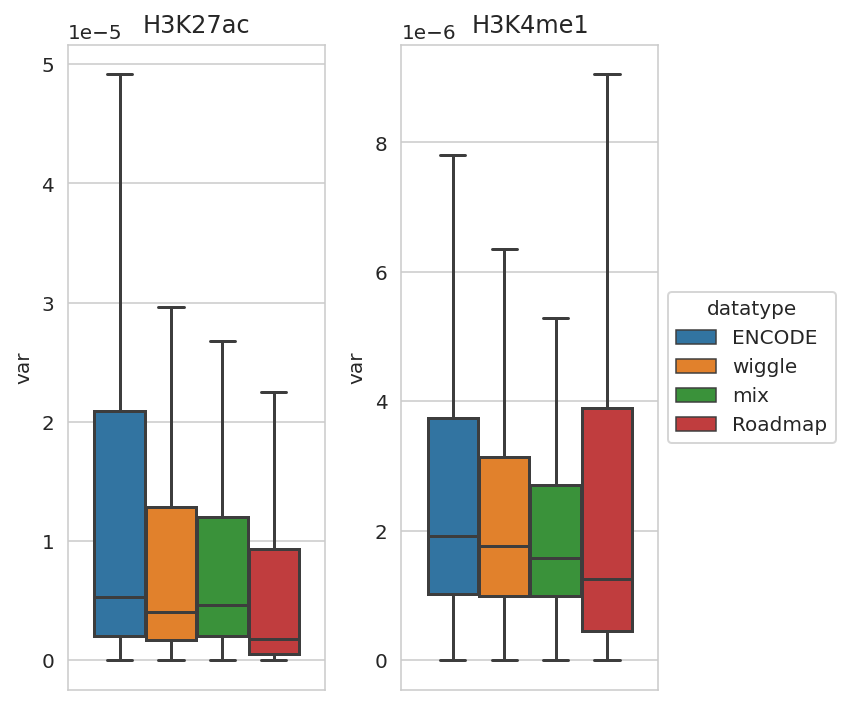

In [75]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_stability[df_stability['modification'] == m], 
                            x='modification', y='var', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

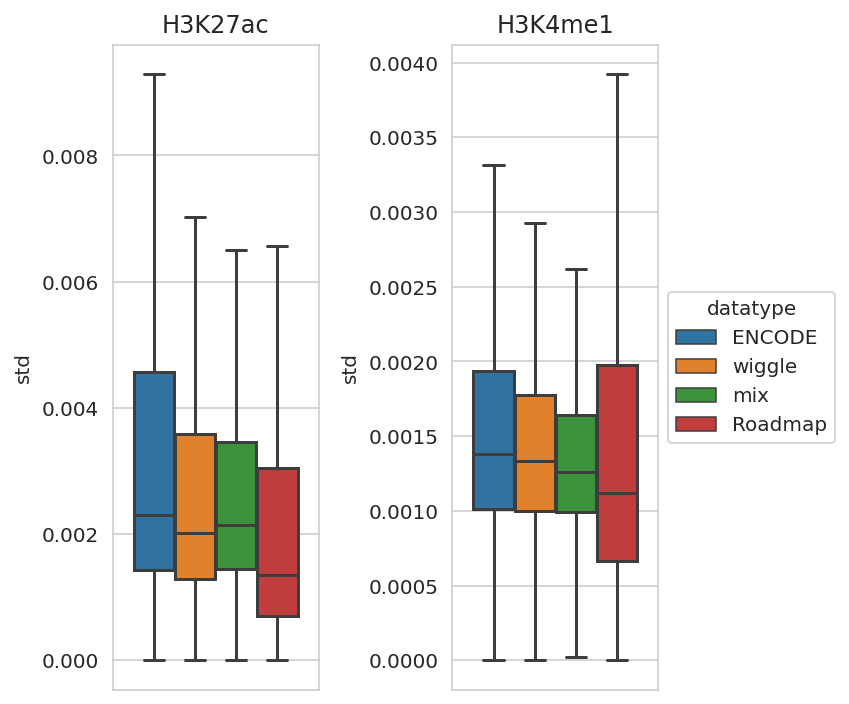

In [76]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_stability[df_stability['modification'] == m], 
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

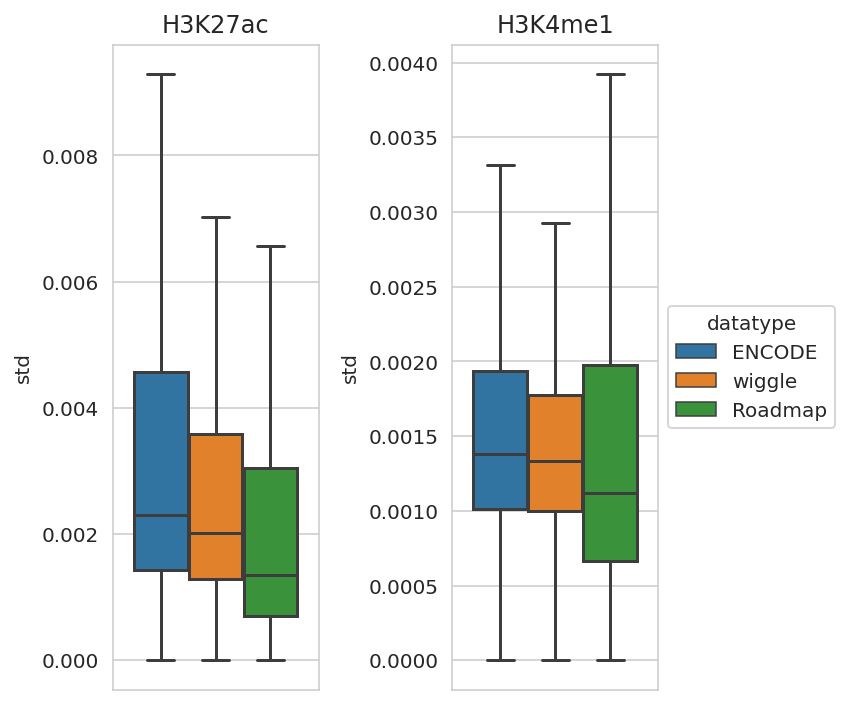

In [77]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_stability[df_stability['modification'] == m], 
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [78]:
df_stability[
    ['datatype', 'modification', 'cell', 'replicate', 'std']
].groupby(['datatype', 'modification', 'cell', 'replicate']).count()

std
datatype modification cell    replicate      
ENCODE   H3K27ac      GM12878 rep1        999
                              rep2        998
                      H1      rep1       1000
                      HMEC    rep1       1000
                              rep2        999
...                                       ...
wiggle   H3K4me1      HepG2   rep1       1000
                      Huvec   rep1       1000
                      K562    rep1        999
                      NHEK    rep1       1000
                      NHLF    rep1       1000

[70 rows x 1 columns]

In [79]:
df_stability_aggr = df_stability[
    ['datatype', 'modification', 'cell', 'replicate', 'var', 'std']
].groupby(['datatype', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_stability_aggr.sample(3)

datatype modification     cell replicate       var       std
6    ENCODE      H3K27ac     HSMM      rep2  0.000024  0.003708
10   ENCODE      H3K27ac    Huvec      rep2  0.000025  0.003848
46      mix      H3K4me1  GM12878      rep1  0.000002  0.001251

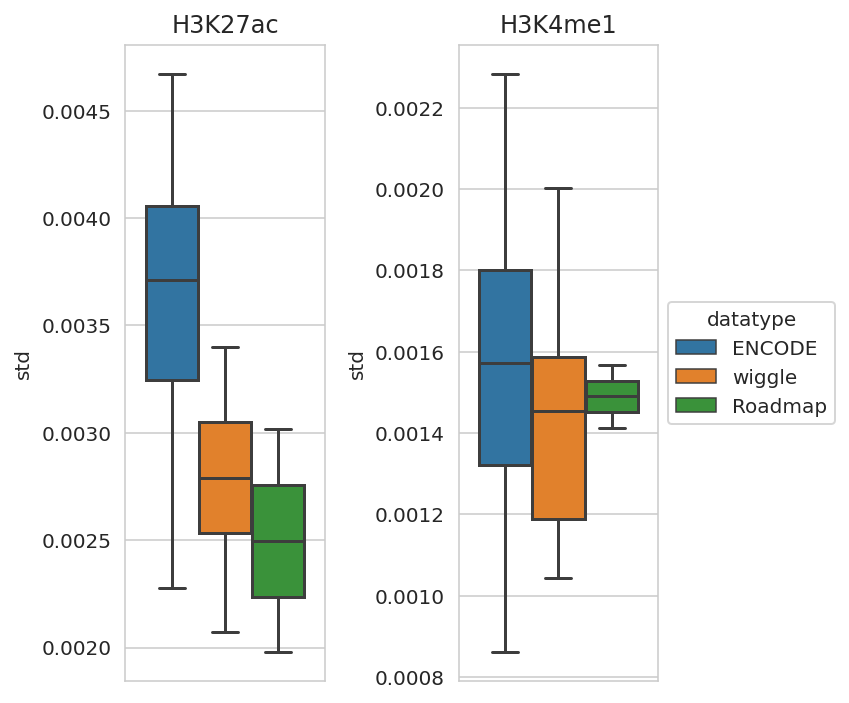

In [80]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_stability_aggr[df_stability_aggr['modification'] == m], 
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## Compute signal/control ratio within peaks

In [81]:
from math import ceil
import pyBigWig

ratios = []

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    control_dt = 'Roadmap' if dt == 'Roadmap' else 'ENCODE'
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        bwc_path = df_bws[(df_bws['dataset'] == control_dt) &
                          (df_bws['modification'] == 'Control') & (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
        print(bwc_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total signal coverage', total_coverage)
            with pyBigWig.open(bwc_path) as bwc:
                # Resort top scored peaks by density and start with the most dense ones
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print('Total control coverage', total_coveragec)

                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in CHROM_SIZES:
                        # Normalize by total coverage
                        signal = bw.stats(chr, start, end, exact=True, type='sum')[0] / total_coverage
                        noise = bwc.stats(chr, start, end, exact=True, type='sum')[0] / total_coveragec
                        ratios.append((dt, m, c, r, f'{chr}:{start}-{end}', (signal + 1e-10) / (noise + 1e-10)))
    except:
        pass  # Ignore

df_signal_to_control = pd.DataFrame(ratios, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'signal_to_control'])
del ratios
df_signal_to_control.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646356_HepG2_H3K27ac_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646371_HepG2_Input_rep2.bw
Total signal coverage 81.26528048207307
Total control coverage 84.38019864613723
ENCODE H3K27ac GM12878 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
Total signal coverage 96.86748202932358
Total control coverage 98.62312218796158
ENCODE H3K27ac H1 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_H1_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646336_H1_H3K27ac_rep1.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646351_H1_Input_rep1.bw
Total signal coverage 79.87111982601976
Total control coverage 81.27345126482821
ENCODE H3K27ac NHLF rep

datatype modification     cell replicate                  position  \
29343   ENCODE      H3K4me1    HepG2      rep1  chr5:146212800-146214399   
42868      mix      H3K27ac     K562      rep1      chr5:6371600-6381799   
14918   ENCODE      H3K4me1  GM12878      rep1   chr20:14901200-14903199   
22039   ENCODE      H3K4me1    Huvec      rep1  chr7:128073400-128077599   
6514    ENCODE      H3K4me1     NHLF      rep2   chr18:73962121-73962753   

       signal_to_control  
29343           4.718961  
42868           2.166925  
14918           5.664607  
22039           9.331498  
6514            3.476563

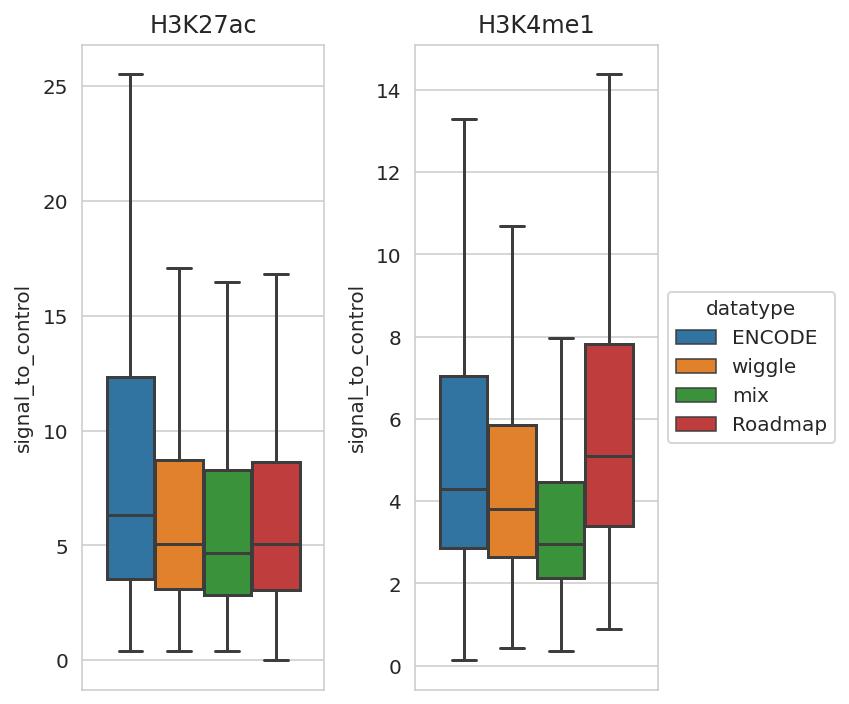

In [82]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_signal_to_control[df_signal_to_control['modification'] == m], x='modification', y='signal_to_control', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Signal-to-noise ratio

In [83]:
# TODO

# Jaccard vs original peaks

In [84]:
bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'type',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for ds, m, c, r, tool in tqdm(
        [('ENCODE', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], GSE26320_CELLS, GSE26320_REPS, TOOLS)] +
        [('Roadmap', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)]
):
    print(ds, m, c, r, tool)
    t = all_wiggle_mix_roadmap_peaks[
        # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                     (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                     (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                     (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                     (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                     (all_wiggle_mix_roadmap_peaks['type'] == 'original')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    for ty in ['wiggle', 'mix']:
        t = all_wiggle_mix_roadmap_peaks[
            # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                         (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                         (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                         (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                         (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                         (all_wiggle_mix_roadmap_peaks['type'] == ty)]
        if len(t) == 0:
            print(ty, '--')
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        overlap1 = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        overlap2 = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        bench_df.loc[len(bench_df)] = \
            (ds, m, c, r, tool, ty,
             original_peaks, original_peaks_len,
             peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


  0%|          | 0/160 [00:00<?, ?it/s]

ENCODE H3K27ac GM12878 rep1 MACS2
ENCODE H3K27ac GM12878 rep1 MACS2 broad
ENCODE H3K27ac GM12878 rep1 SPAN
ENCODE H3K27ac GM12878 rep1 SICER
ENCODE H3K27ac GM12878 rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 SICER
wiggle --
mix --
ENCODE H3K27ac HMEC rep1 MACS2
ENCODE H3K27ac HMEC rep1 MACS2 broad
ENCODE H3K27ac HMEC rep1 SPAN
ENCODE H3K27ac HMEC rep1 SICER
ENCODE H3K27ac HMEC rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 SICER
wiggle --
mix --
ENCODE H3K27ac HSMM rep1 MACS2
ENCODE H3K27ac HSMM rep1 MACS2 broad
ENCODE H3K27ac HSMM rep1 SPAN
ENCODE H3K27ac HSMM rep1 SICER
ENCODE H3K27ac HSMM rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 SICER
wiggle --
mix -

dataset modification   cell replicate         name    type  \
116  ENCODE      H3K4me1  Huvec      rep1         SPAN  wiggle   
99   ENCODE      H3K4me1   NHEK      rep1  MACS2 broad     mix   
115  ENCODE      H3K4me1  Huvec      rep1  MACS2 broad     mix   

     original_peaks  original_peaks_len  peaks  peaks_len  overlap1  overlap2  \
116           75212           125066353  64235  143081329     69234     61771   
99            84110           140679669  45485   22294321     26923     45484   
115           60955           104800097  41239   19501271     23461     41239   

     overlap_len  
116    118173281  
99      22288230  
115     19497243

In [85]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


dataset modification  cell replicate   name type  original_peaks  \
81  ENCODE      H3K4me1  HSMM      rep1  MACS2  mix           58144   

    original_peaks_len  peaks  peaks_len  overlap1  overlap2  overlap_len  \
81            27943823   1458     511298      1405      1458       511058   

     jaccard  
81  0.018289

H3K27ac
H3K4me1


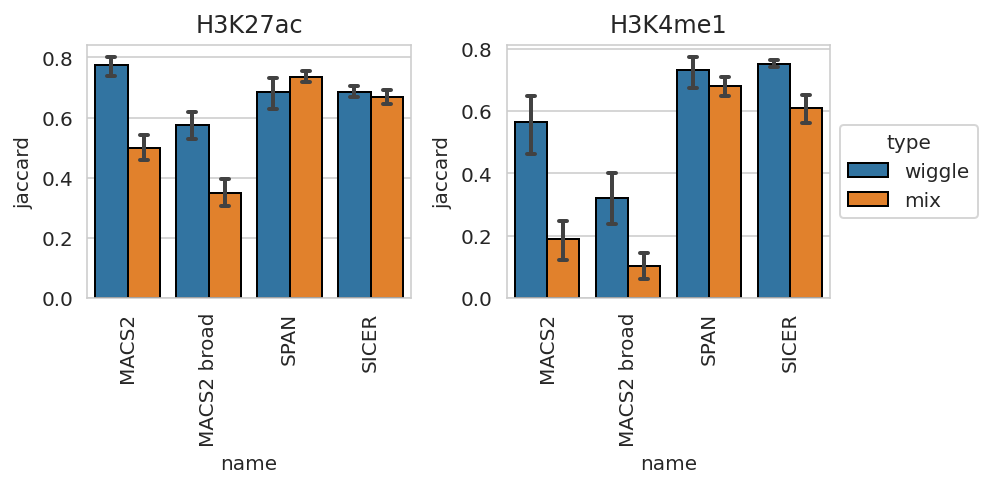

In [86]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='type', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


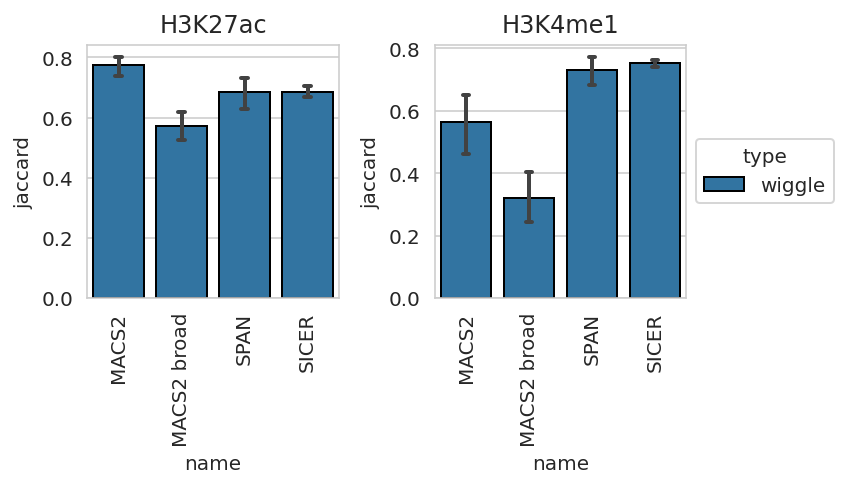

mix
H3K27ac
H3K4me1


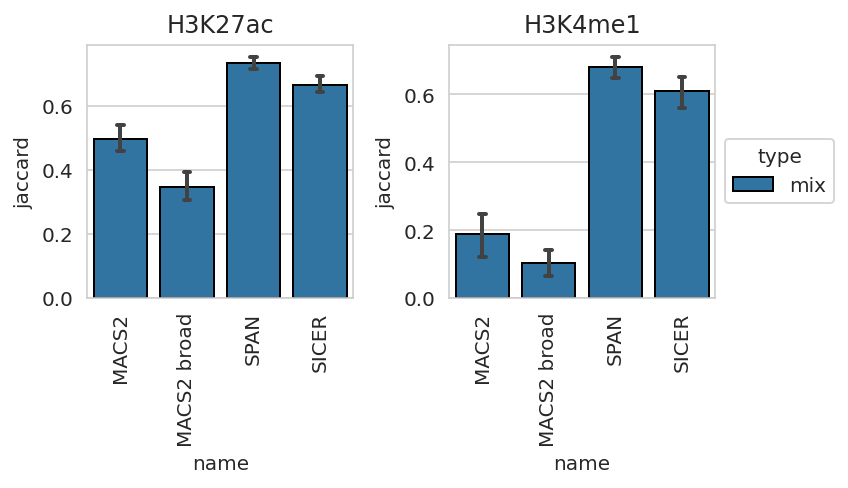

In [87]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(6, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=bench_df[(bench_df['type'] == ty) & (bench_df['modification'] == m)],
                                x='name', hue='type', y='jaccard', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['wiggle', 'mix'],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Coverage instability (std) in peaks region example

In [88]:
xs = [3,6,20,13,7,15,12,15,7,2]
print(sum(xs), np.var(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print(sum(ys), np.var(ys))

100 31.0
100 23.6


In [89]:
diff_bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'peaks', 'peakslen', 'averagelen'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    # Process single tool information
    span_file = None
    for tool in TOOLS:
        print(ds, m, c, r, tool)
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = bedl(file).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, tool, peaks, peaks_len, average_len) 
        if tool == 'SPAN':
            span_file = file
            
    # Processing SPAN difference
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = bedl(tf).sum()
            average_len = d(peaks_len,  peaks)
            diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, name, peaks, peaks_len, average_len)
    
    # Processing exclusive peaks        
    for tool in TOOLS:
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        other_tool_files = []
        for ot in TOOLS:
            if ot == tool:
                continue
            t = df_peaks[
                (df_peaks['dataset'] == ds) &
                (df_peaks['modification'] == m) &
                (df_peaks['cell'] == c) &
                (df_peaks['replicate'] == r) &
                (df_peaks['tool'] == ot)]
            if len(t) == 0:
                continue
            other_tool_files.append(sorted_file(t['file'].values[0]))
        other_tool_files_str = ' '.join(other_tool_files)

        ! bedtools multiinter -i {other_tool_files_str} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
        peaks = lines(tf)
        peaks_len = bedl(tf).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, f'{tool} only', peaks, peaks_len, average_len)

display(diff_bench_df.sample(3))

  0%|          | 0/100 [00:00<?, ?it/s]

ENCODE H3K4me3 GM12878 rep1 MACS2
ENCODE H3K4me3 GM12878 rep1 MACS2 broad
ENCODE H3K4me3 GM12878 rep1 SPAN
ENCODE H3K4me3 GM12878 rep1 SICER
ENCODE H3K4me3 GM12878 rep2 MACS2
ENCODE H3K4me3 GM12878 rep2 MACS2 broad
ENCODE H3K4me3 GM12878 rep2 SPAN
ENCODE H3K4me3 GM12878 rep2 SICER
ENCODE H3K4me3 HMEC rep1 MACS2
ENCODE H3K4me3 HMEC rep1 MACS2 broad
ENCODE H3K4me3 HMEC rep1 SPAN
ENCODE H3K4me3 HMEC rep1 SICER
ENCODE H3K4me3 HMEC rep2 MACS2
ENCODE H3K4me3 HMEC rep2 MACS2 broad
ENCODE H3K4me3 HMEC rep2 SPAN
ENCODE H3K4me3 HMEC rep2 SICER
ENCODE H3K4me3 HSMM rep1 MACS2
ENCODE H3K4me3 HSMM rep1 MACS2 broad
ENCODE H3K4me3 HSMM rep1 SPAN
ENCODE H3K4me3 HSMM rep1 SICER
ENCODE H3K4me3 HSMM rep2 MACS2
ENCODE H3K4me3 HSMM rep2 MACS2 broad
ENCODE H3K4me3 HSMM rep2 SPAN
ENCODE H3K4me3 HSMM rep2 SICER
ENCODE H3K4me3 K562 rep1 MACS2
ENCODE H3K4me3 K562 rep1 MACS2 broad
ENCODE H3K4me3 K562 rep1 SPAN
ENCODE H3K4me3 K562 rep1 SICER
ENCODE H3K4me3 K562 rep2 MACS2
ENCODE H3K4me3 K562 rep2 MACS2 broad
ENCOD

dataset modification   cell replicate          name  peaks     peakslen  \
698   ENCODE      H3K4me1  HepG2      rep1     SPAN only   9267    3529018.0   
610   ENCODE      H3K4me1   NHLF      rep1  SPAN - SICER   9635    5606708.0   
1039  ENCODE     H3K36me3   K562      rep1         SICER  34144  269764056.0   

       averagelen  
698    380.815582  
610    581.910535  
1039  7900.774836

In [90]:
diff_bench_df.to_csv(os.path.expanduser('~/data/datasets.csv'), index=False)

0it [00:00, ?it/s]

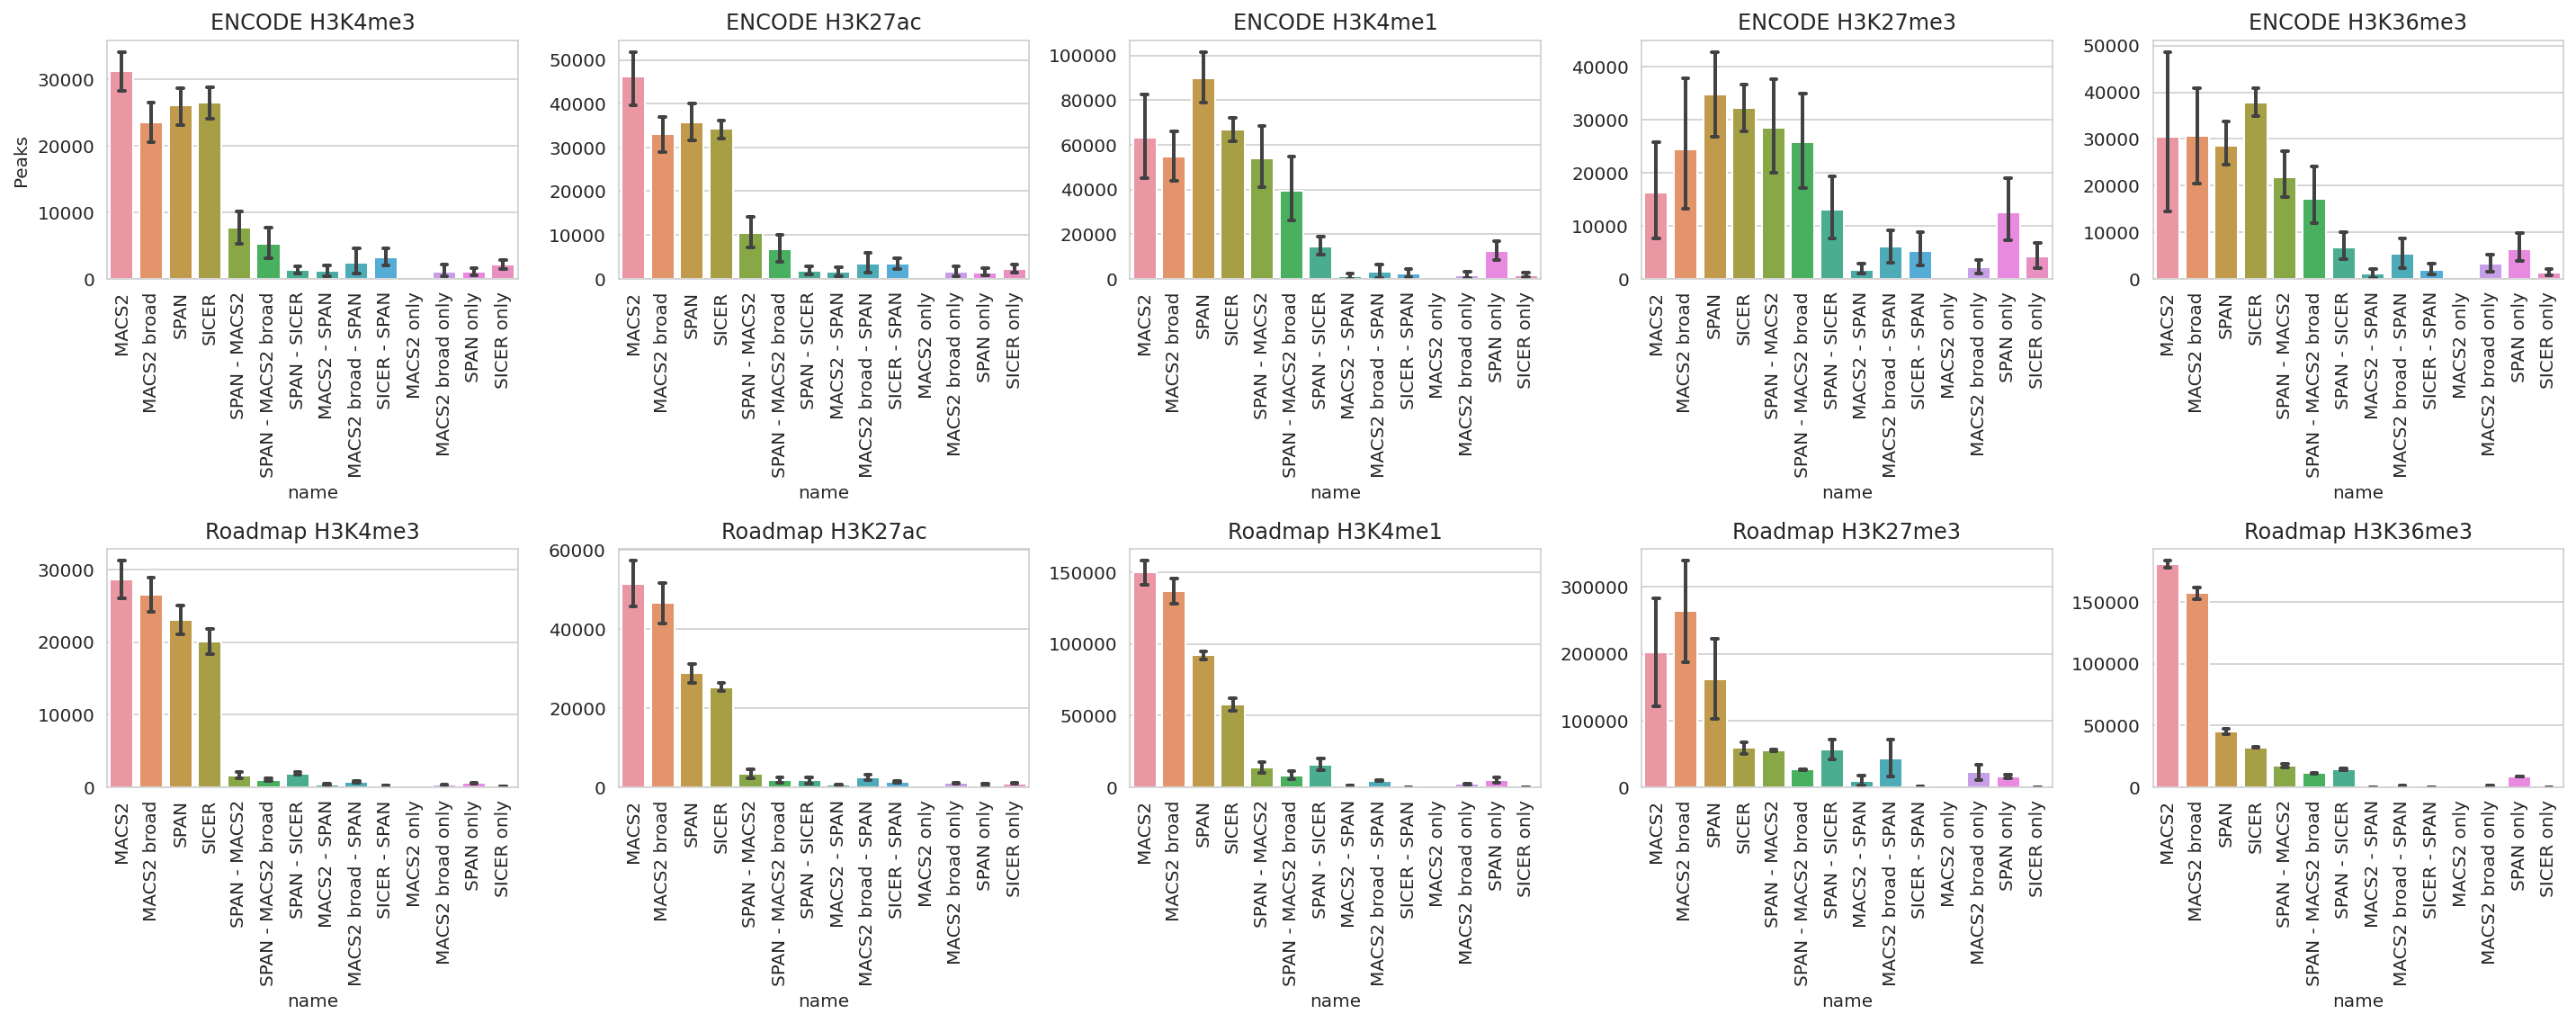

In [91]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Peaks')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

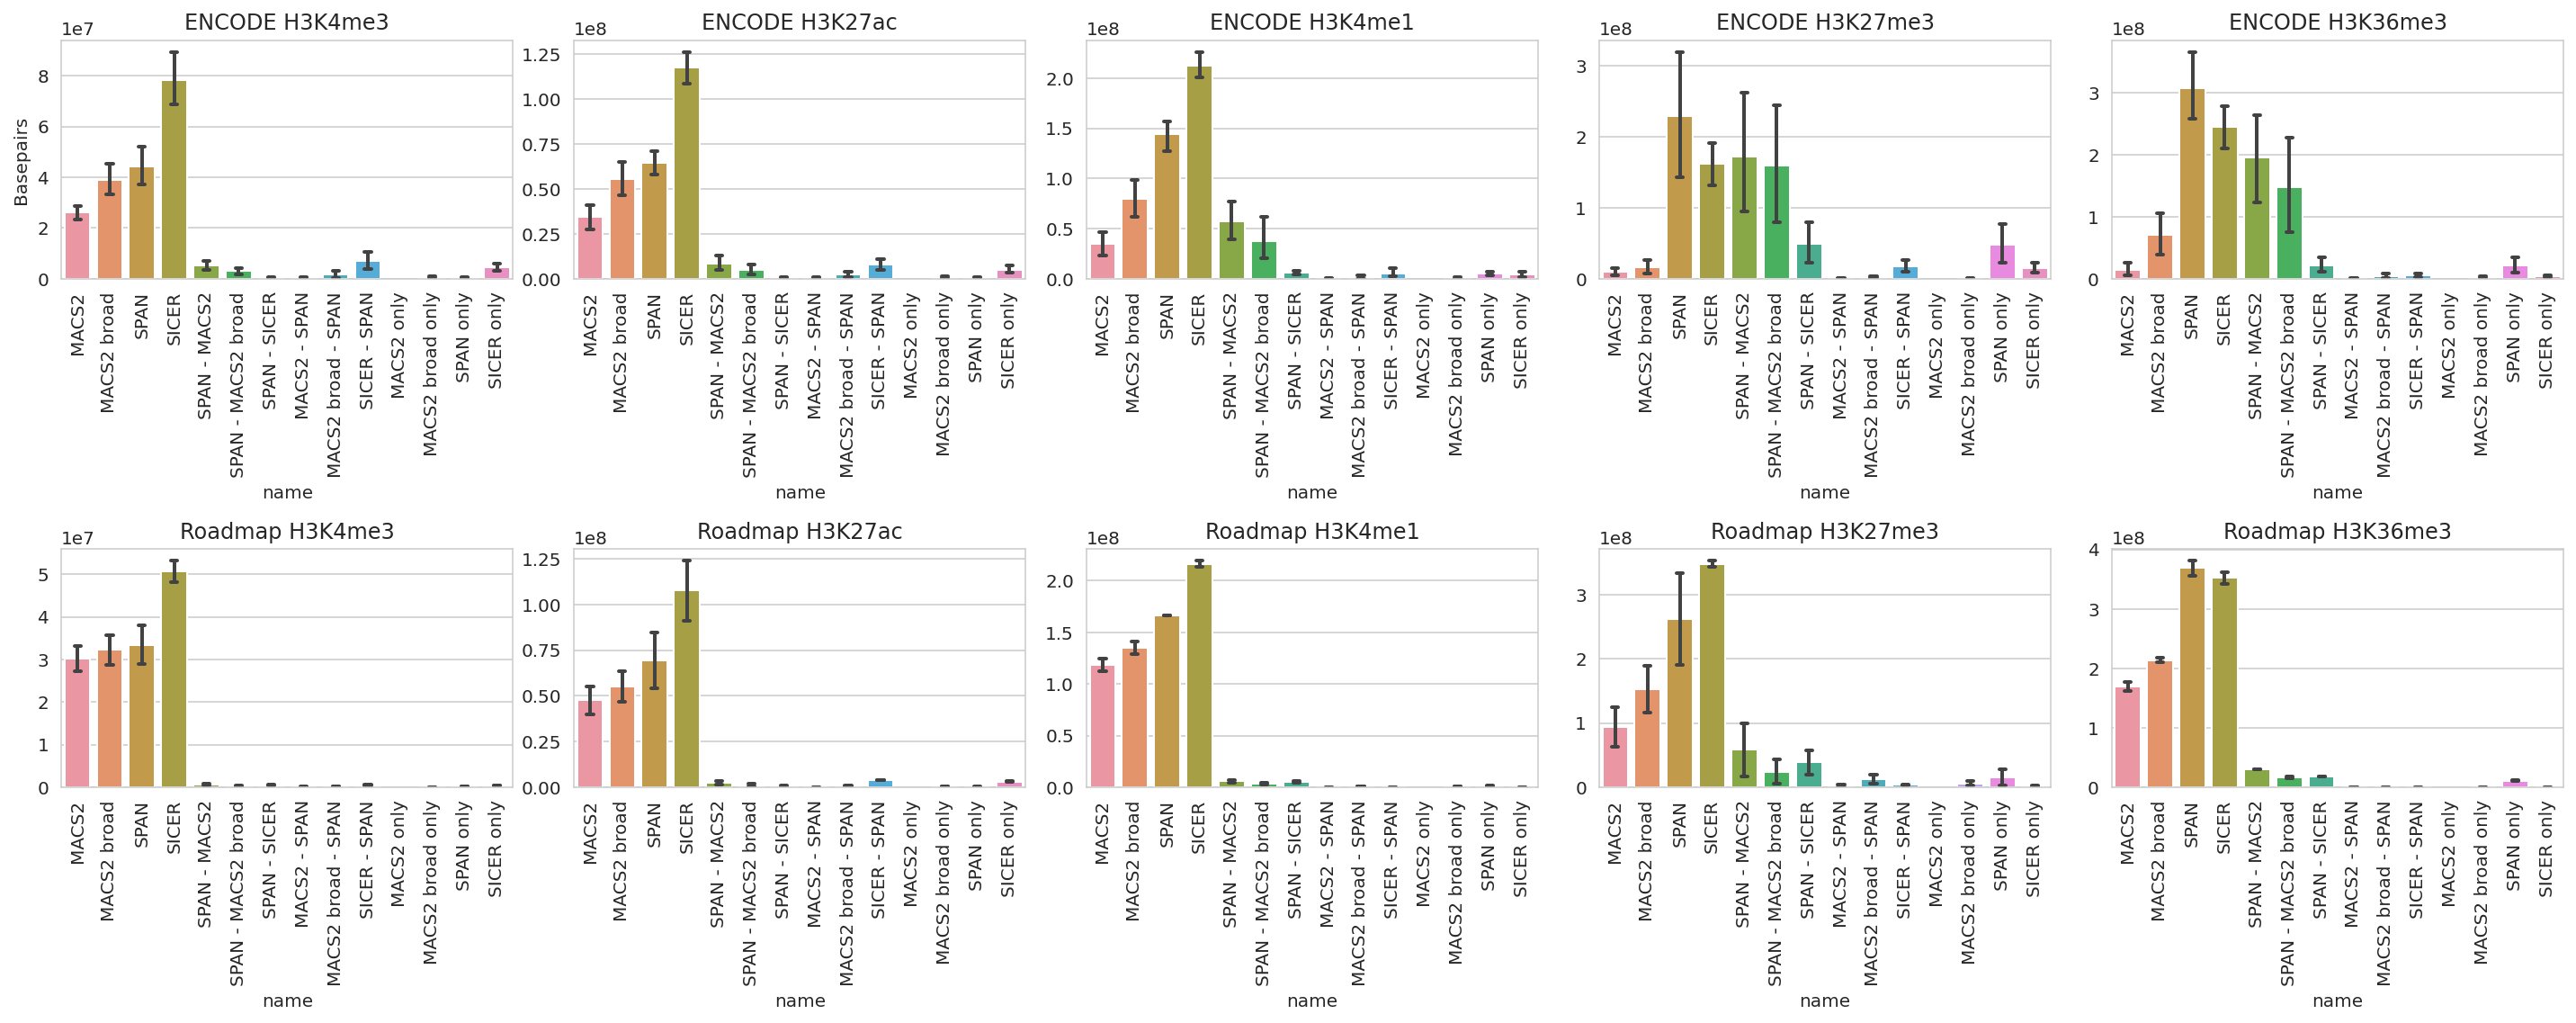

In [92]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peakslen',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Basepairs')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

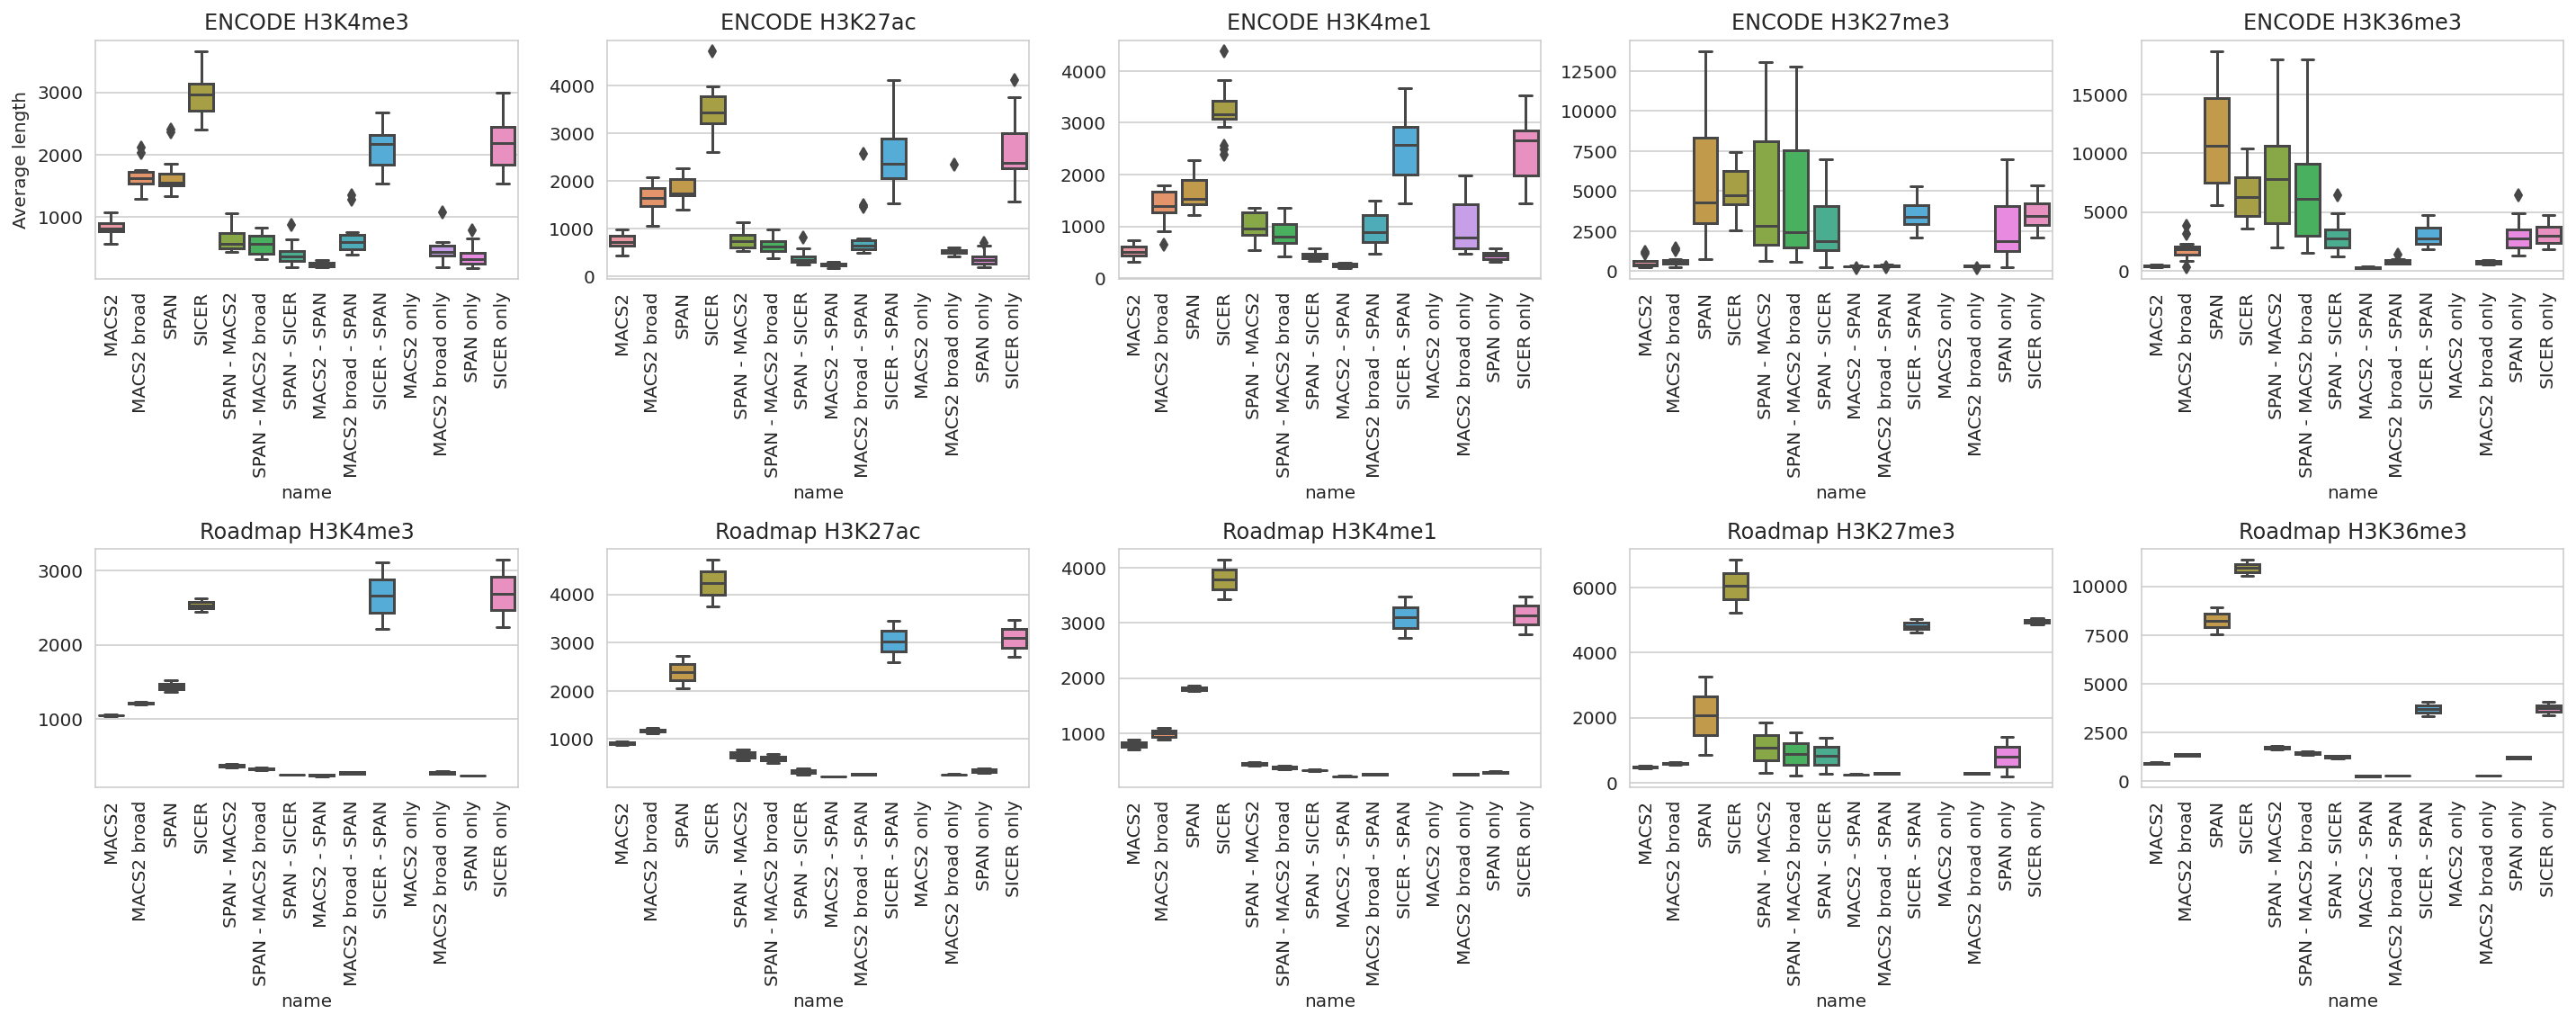

In [93]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) & 
                                               (diff_bench_df['modification']==m) & 
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='averagelen',
                            ax=ax,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Average length')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    
plt.tight_layout()
plt.show()

## Compute signal / control coverage RPKM

In [126]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

def load_rpkms(path, bw, bwc, total_coverage, total_coveragec, n=1000):
    if lines(path) == 0:
        return []
    t = pd.read_csv(path, sep='\t', header=None)
    t = t.sample(min(len(t), n))
    
    for chr, start, end in zip(t[0], t[1], t[2]):
        if chr in CHROM_SIZES:
            # Normalize by total coverage
            signal = bw.stats(chr, start, end, exact=False, type='sum')[0] / total_coverage
            noise = bwc.stats(chr, start, end, exact=False, type='sum')[0] / total_coveragec
            yield f'{chr}:{start}-{end}', d(signal, (end - start) / 1e3), d(noise, (end - start) / 1e3)

def rpkms_to_df(rpkm_gen, ds, mod, cell, rep, name):
    positions = []
    rpkms = []
    rpkmcs = []
    for p, r, rc in rpkm_gen:
        positions.append(p)
        rpkms.append(r)
        rpkmcs.append(rc)
    t = pd.DataFrame(data={'position': positions * 3, 
                            'RPKM': rpkms + rpkmcs + [d(r, rc) for r, rc in zip(rpkms, rpkmcs)], 
                            'type': ['signal'] * len(positions) + ['control'] * len(positions) + ['signal_to_control'] * len(positions)})
    t['dataset'] = ds
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['name'] = name
    return t

ts = []

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    try:
        bw_path = df_bws[(df_bws['dataset'] == ds) &
                         (df_bws['modification'] == m) &
                         (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        bwc_path = df_bws[(df_bws['dataset'] == ds) &
                          (df_bws['modification'] == 'Control') &
                          (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
    
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            with pyBigWig.open(bwc_path) as bwc:
                print(ds, m, c, r, 'Total signal coverage', total_coverage)
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print(ds, m, c, r, 'Total control coverage', total_coveragec)
                print('Process single tool information')
                span_file = None
                for tool in TOOLS:
                    # print(ds, m, c, r, tool)
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    file = sorted_file(t['file'].values[0])
                    ts.append(rpkms_to_df(load_rpkms(file, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, tool))
                    if tool == 'SPAN':
                        span_file = file

                print('Processing SPAN difference')
                for tool in TOOLS:
                    if tool == 'SPAN':
                        continue
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    for name, args in [
                        (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                        (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
                    ]:
                        ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
                        ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, name))

                print('Processing exclusive peaks')        
                for tool in TOOLS:
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    other_tool_files = []
                    for ot in TOOLS:
                        if ot == tool:
                            continue
                        t = df_peaks[
                            (df_peaks['dataset'] == ds) &
                            (df_peaks['modification'] == m) &
                            (df_peaks['cell'] == c) &
                            (df_peaks['replicate'] == r) &
                            (df_peaks['tool'] == ot)]
                        if len(t) == 0:
                            continue
                        other_tool_files.append(sorted_file(t['file'].values[0]))
                    other_tool_files_str = ' '.join(other_tool_files)

                    ! bedtools multiinter -i {other_tool_files_str} > {tf}
                    ! bedtools merge -i {tf} > {tf2}
                    ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
                    ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, f'{tool} only'))
    except:
        continue

diff_bench_coverage_df = pd.concat(ts).reset_index(drop=True)
del ts
display(diff_bench_coverage_df.sample(3))

  0%|          | 0/100 [00:00<?, ?it/s]

ENCODE H3K4me3 GM12878 rep1 Total signal coverage 98.01645679722262
ENCODE H3K4me3 GM12878 rep1 Total control coverage 98.77364358120919
Process single tool information
Processing SPAN difference
Processing exclusive peaks
ENCODE H3K4me3 GM12878 rep2 Total signal coverage 97.2194230629096
ENCODE H3K4me3 GM12878 rep2 Total control coverage 98.62312218796158
Process single tool information
Processing SPAN difference
Processing exclusive peaks
ENCODE H3K4me3 HMEC rep1 Total signal coverage 76.10169911290144
ENCODE H3K4me3 HMEC rep1 Total control coverage 80.53955714026546
Process single tool information
Processing SPAN difference
Processing exclusive peaks
ENCODE H3K4me3 HMEC rep2 Total signal coverage 80.91100208822728
ENCODE H3K4me3 HMEC rep2 Total control coverage 83.66976373778391
Process single tool information
Processing SPAN difference
Processing exclusive peaks
ENCODE H3K4me3 HSMM rep1 Total signal coverage 79.88705708949948
ENCODE H3K4me3 HSMM rep1 Total control coverage 83.27372

position      RPKM               type dataset  \
2279981   chr13:21546510-21547449  1.681890  signal_to_control  ENCODE   
1879755   chr16:79652833-79657061  0.268501            control  ENCODE   
1964805  chr1:244111095-244111438  3.498916             signal  ENCODE   

        modification   cell  replicate                name  
2279981     H3K36me3   K562   1.339995  SPAN - MACS2 broad  
1879755     H3K27me3   NHLF   1.197745        SPAN - MACS2  
1964805     H3K27me3  Huvec   2.118035  MACS2 broad - SPAN

0it [00:00, ?it/s]

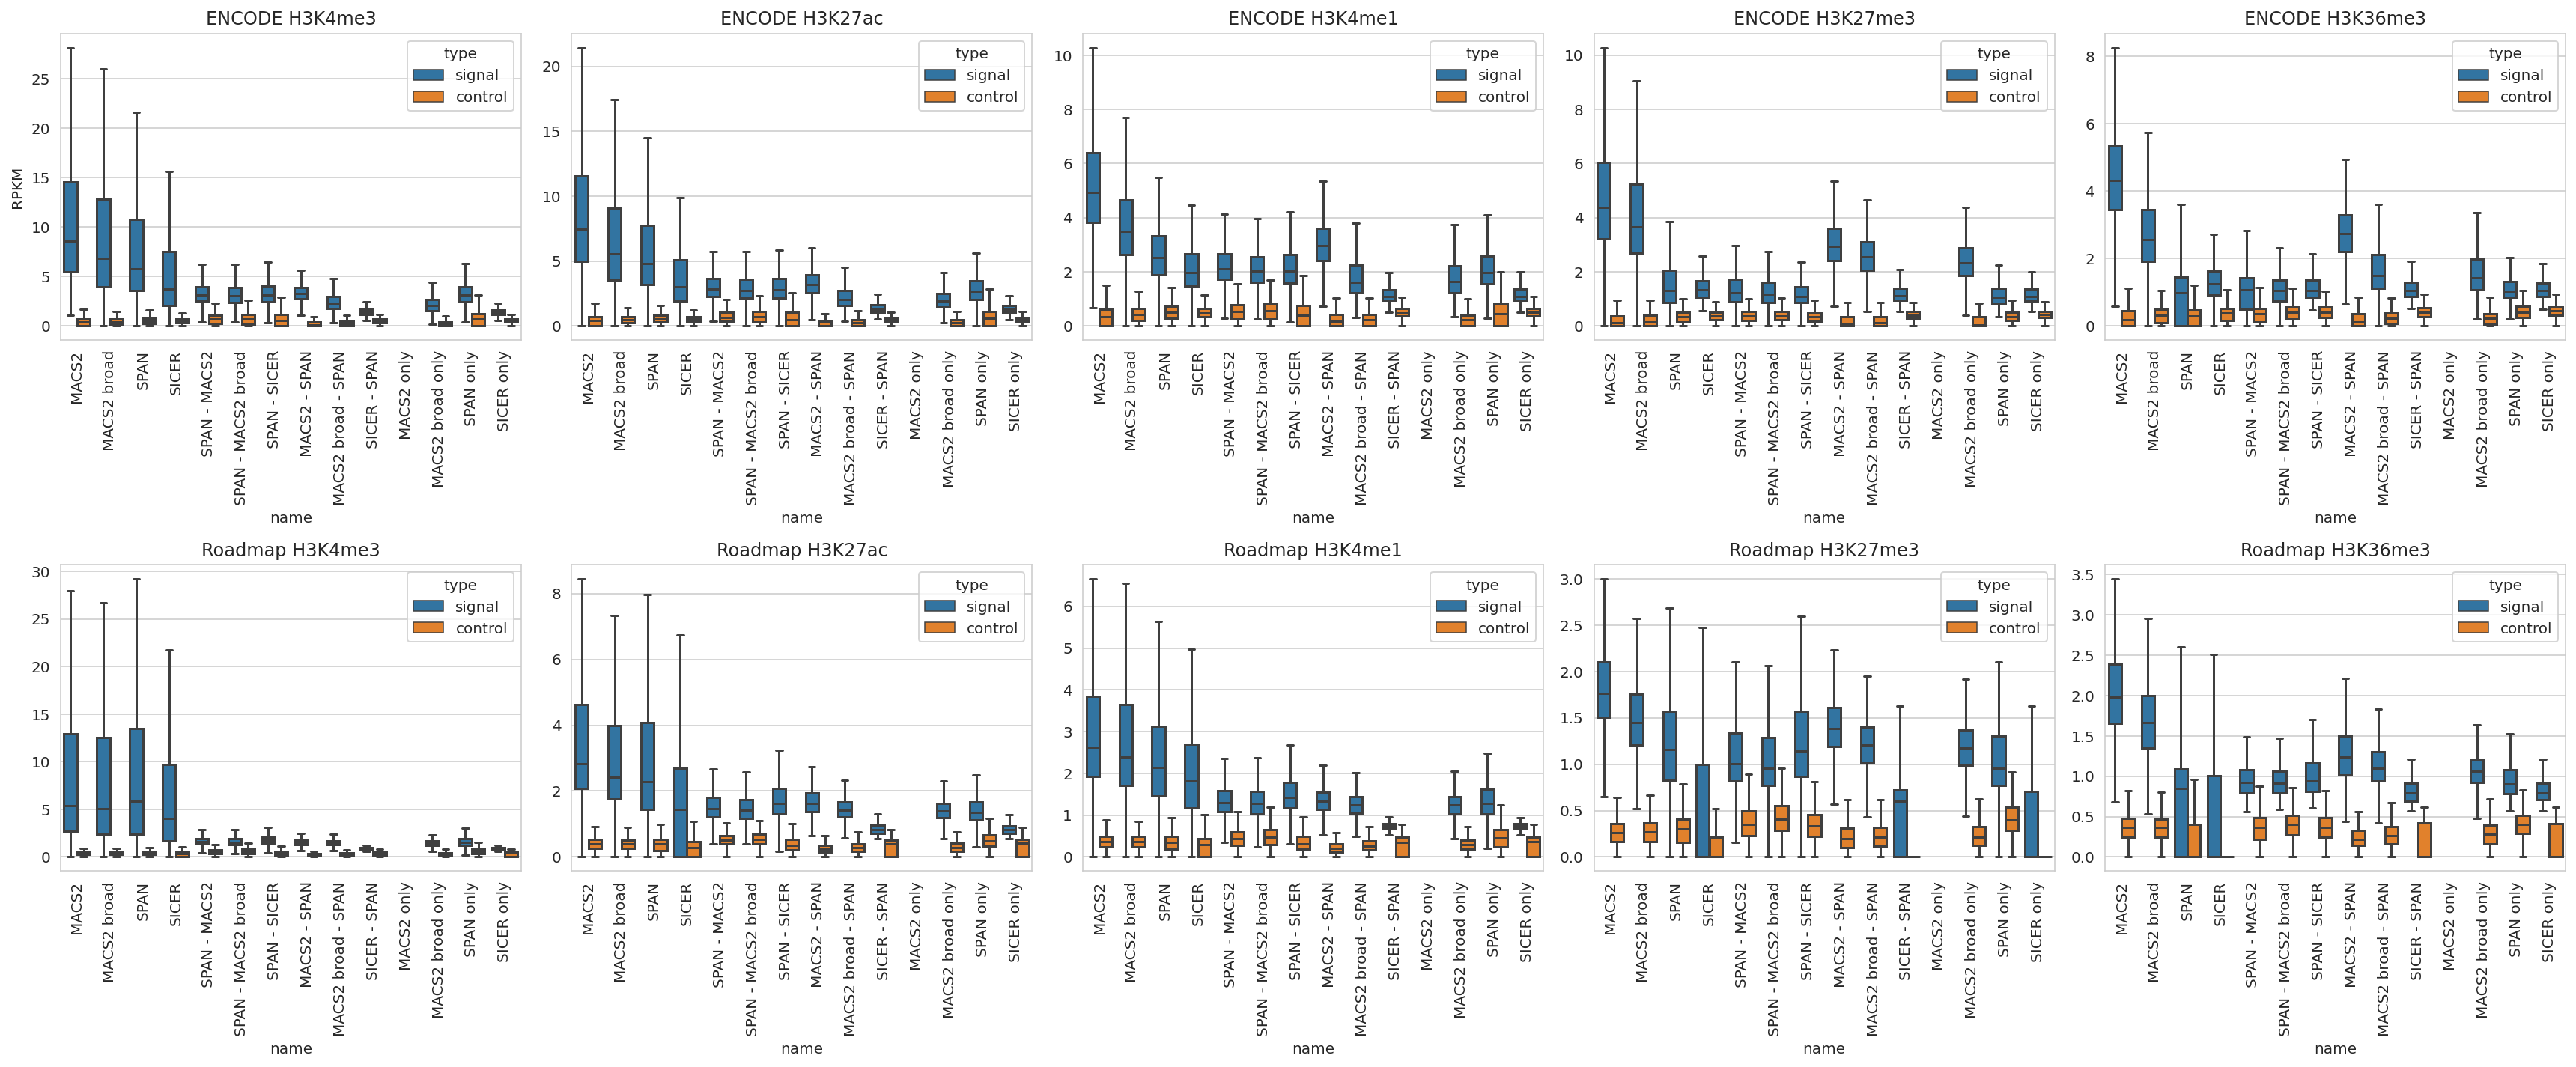

In [127]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] != 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m)],
                            x='name', y='RPKM', hue='type',
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('RPKM')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

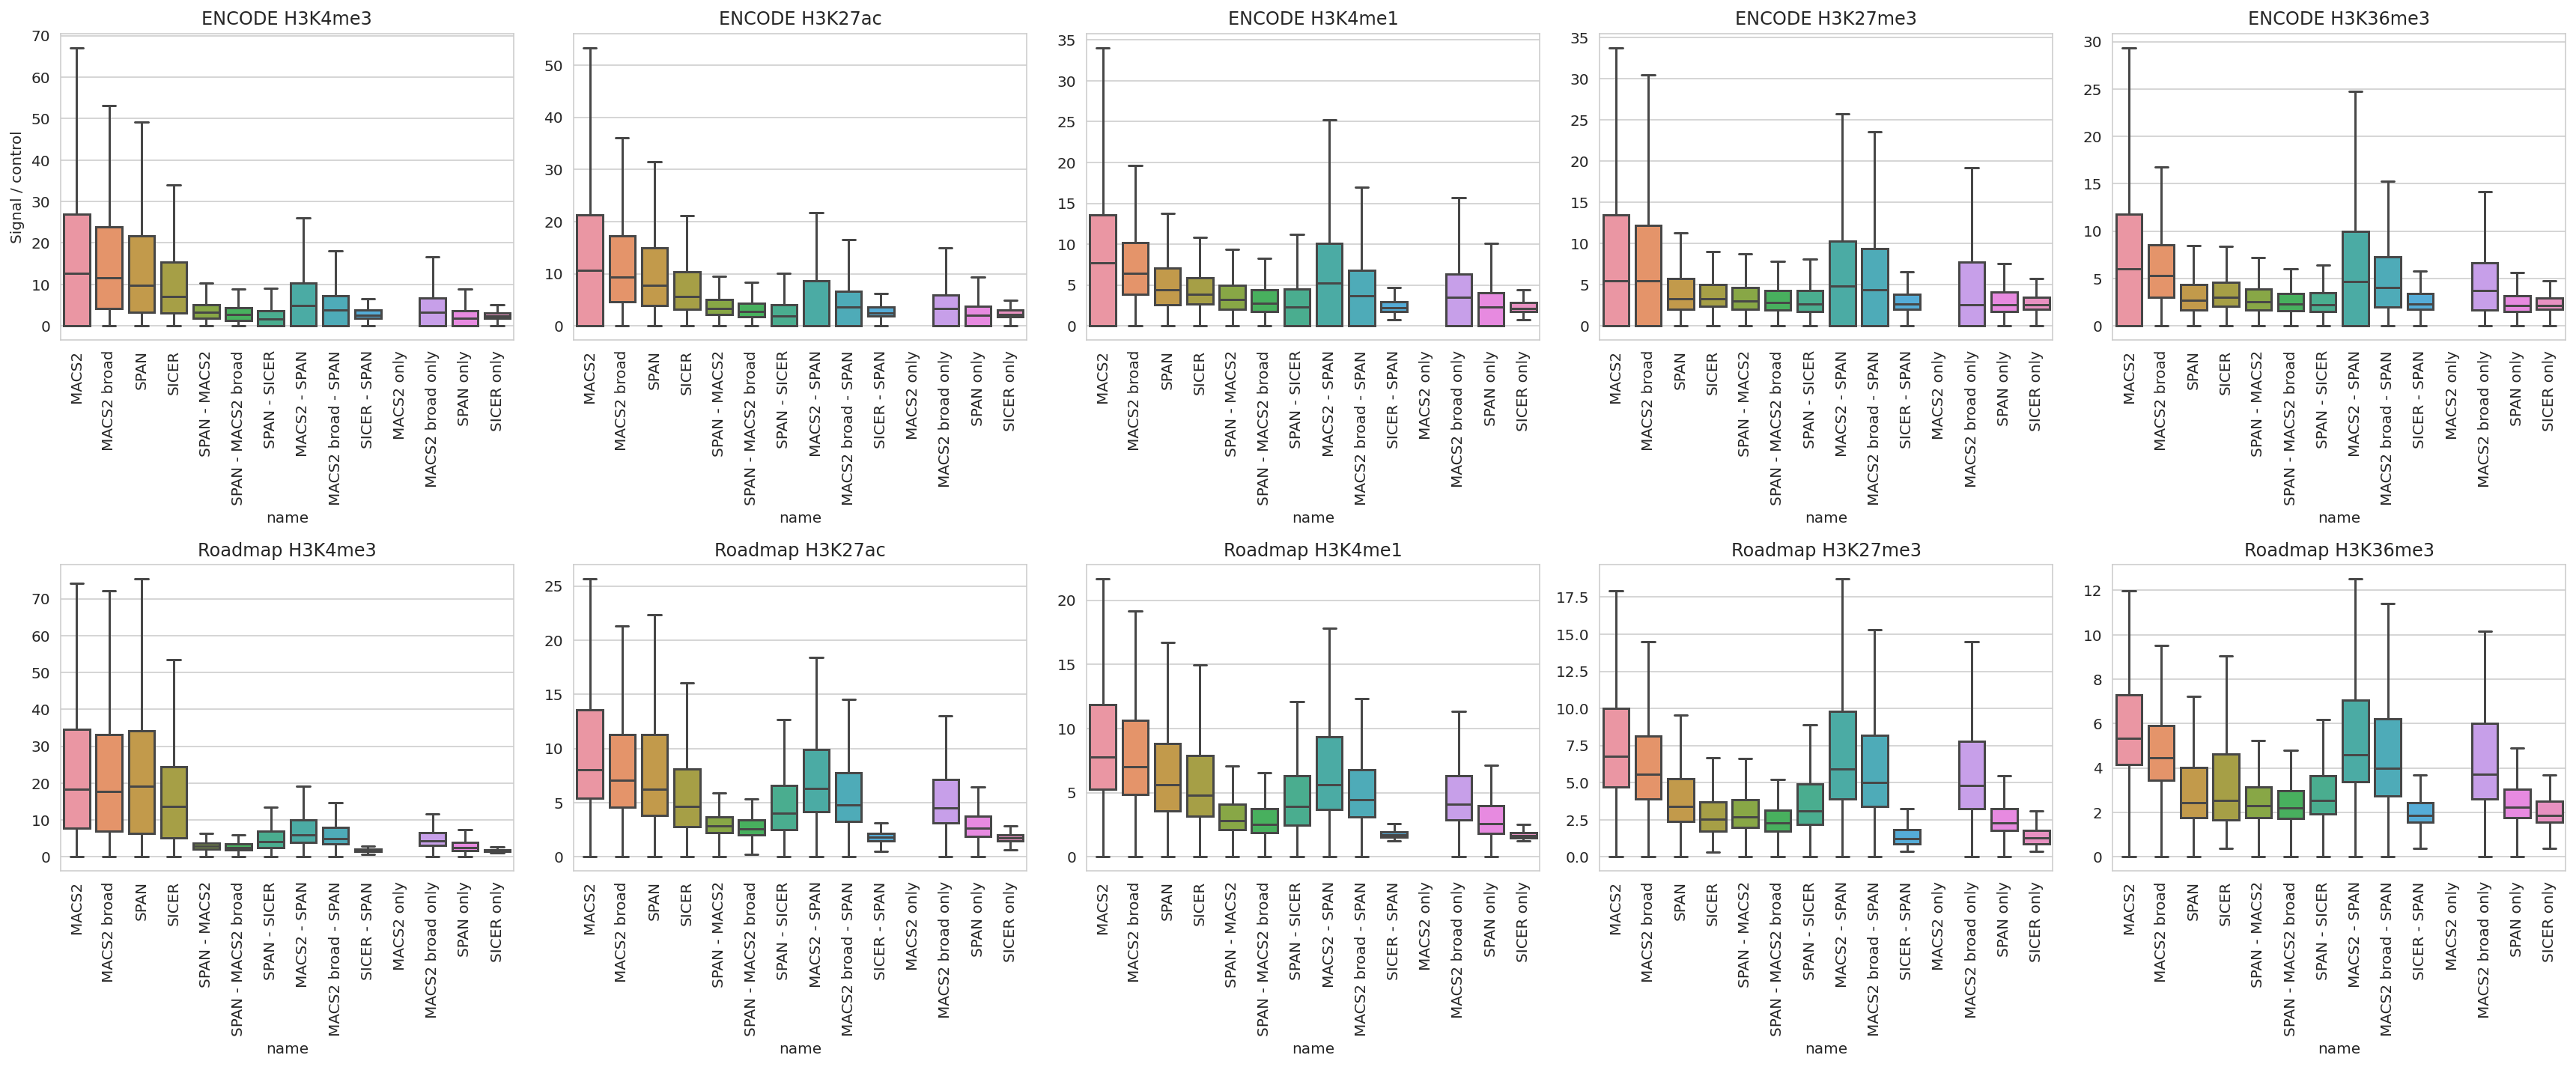

In [136]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] == 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m) &
                                                        (diff_bench_coverage_df['RPKM']<1000)],
                            x='name', y='RPKM', 
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Signal / control')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# END